[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/ahvshim/fix-the-data-first-then-worry-about-the-model/notebook)

<div style="border-radius:10px; border:#e7c6ff solid; padding: 15px; background-color: #f6f5f5; font-size:100%; text-align:left">

Image classification is one of the core supervised learning tasks. The goal is simple: train a model on labeled images so it can correctly predict the class of new, unseen ones. During training, the model learns from labeled examples, makes predictions, evaluates its performance using a loss function, and adjusts its internal weights through optimization techniques like gradient descent

But here's the catch: supervised learning only works well if your data is solid. You need enough labeled samples for the model to learn from, and if the labels are noisy or scarce, you're in trouble. There's a golden rule in machine learning that goes:

<h2 style="font-size: 42px; font-family: 'Roboto Mono', monospace; color: #2a1a3a; text-align: center; max-width: 2000px;">
  Fix the <b style="color: #b8860b;">data</b> first, then worry about the model
</h2>


This project is a perfect case study for that.

<div style="border-radius:10px; border:#e7c6ff solid; padding: 15px; background-color: #f6f5f5; font-size:100%; text-align:left">
    
#### The Challenge
 
The task is to classify sheep breeds using a small labeled dataset (`train.csv` + `images`) and make predictions on an unlabeled test set. Sounds straightforward, but there are a few twists that make it harder than it looks:

- **The dataset is small:** We're dealing with just 682 images spread across 7 classes, that's fewer than 100 samples per class

- **The dataset is imbalanced:** Some classes dominate, while others are severely underrepresented. Naturally, the model tends to favor the majority classes and ignore the rest
- **The data isn't perfectly clean:** Some images contain multiple sheep from possibly different breeds. Don't laugh at me but even me as a human, I found it hard to tell them apart sometimes
- **The evaluation metric is F1 score:** F1 is unforgiving. It only cares whether you got the prediction exactly right. There's no reward for being “close”, even if your model is 95% sure an image is class A but picks class B by mistake, that’s a zero. It’s all or nothing. And with 7 classes to choose from, the odds aren't always in your favor

#### The Plan

In this notebook, I walk through a full pipeline to tackle the above issues using a semi-supervised approach. Here’s what we’ll do:

- First, we split the labeled data for 5-fold cross-validation
- We apply strong augmentations to the training images, and just resizing + normalization for validation
- Since the classes are imbalanced, we compute class weights and pass them to the cross-entropy loss function

For modeling, we’ll use a Vision Transformer (ViT) backbone with a custom classification head

Then we move in two main stages:

1. Initial Training
    We train the model using cross-validation only on the labeled data

2. Pseudo-Labeling + Clustering
    We predict on the test set and retain only the most confident predictions. Then, we go one step further by clustering the feature representations of the test images using KMeans and extracting high-purity samples
    These are then **merged** with the training set to form a richer, more confident dataset. The model is retrained again on this merged dataset to produce the final predictions

# 1. Setup and Configuration

Okay, let’s get our hands dirty. First things first, we’ll import the necessary libraries, set up the environment, and define a few configuration values to keep things organized

In [1]:
# ======================
# Standard Library Imports
# ======================
import os
import random
import math
from pathlib import Path
from typing import Any, Dict
import warnings
warnings.filterwarnings('ignore')

# ======================
# 3rd-Party Imports
# ======================
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from collections import Counter
from scipy.spatial.distance import cdist
import umap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

2025-06-19 06:57:44.292161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750316264.477525      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750316264.531043      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let’s define a `Config` object to store all the key settings, things like directory paths, model name, and training parameters. You’ll see this pop up a lot throughout the notebook

**Note:** The variables in this class are used across multiple functions and classes without being passed as arguments, so it’s best not to rename them later on

In [2]:
# ======================
# MAIN CONFIGURATIONS
# ======================
class Config:

    seed=7
    img_size=224
    model_name='vit_base_patch16_224.augreg_in21k_ft_in1k'
    num_classes=7
    batch_size=8
    epochs=50
    lr=1e-4
    min_lr=1e-6
    n_folds=5
    patience=5
    train_csv='/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv'
    train_dir='/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train'
    test_dir='/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test'
    models_dir='models'
    results_dir='results'
    processed_data_dir='processed_data'
    device="cuda" if torch.cuda.is_available() else "cpu"

    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(processed_data_dir, exist_ok=True)

class SeedManager:
    def __init__(self, seed: int):
        self.seed = seed

    def seed_everything(self):
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"Seeds set to: {self.seed}")

In [3]:
CONFIG = Config()
# Setting a seed for reproducibility
SeedManager(CONFIG.seed).seed_everything()

# Creating new folders, for initial results, and final results (will be used later)
INITIAL_RESULTS_DIR = os.path.join(CONFIG.results_dir, "initial_results")
os.makedirs(INITIAL_RESULTS_DIR, exist_ok=True)

PSEUDO_RESULTS_DIR = os.path.join(CONFIG.results_dir, "final_results")
os.makedirs(PSEUDO_RESULTS_DIR, exist_ok=True)

Seeds set to: 7


# 2. Custom Classes, Functions


In this section, we’ll define all the helper classes and functions we’ll be using throughout the notebook

In [4]:
# ======================
# CUSTOM DATASET CLASSES
# ======================
class SheepDataset(Dataset):
    def __init__(self, df=None, image_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

        if self.is_test:
            # For test set, just get sorted list of image files
            self.img_files = sorted(os.listdir(image_dir))
        else:
            # For train/val set, use dataframe with filenames and labels
            self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.img_files) if self.is_test else len(self.df)

    def __getitem__(self, idx):
        if self.is_test:
            filename = self.img_files[idx]
            img_path = os.path.join(self.image_dir, filename)
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)["image"]
            return image, filename
        else:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.image_dir, row["filename"])
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)["image"]
            label = row["label"]
            return image, torch.tensor(label, dtype=torch.long)


class PseudoDataset(Dataset):
    def __init__(self, df, train_dir, test_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"]
        label = row["label"]
        source = row.get("source", "train")
        confidence = row.get(
            "confidence", 1.0
        )  # default to 1.0 for clean training data

        img_dir = self.test_dir if source == "pseudo" or source == "cluster" else self.train_dir
        img_path = os.path.join(img_dir, filename)

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]

        return (
            image,
            torch.tensor(label, dtype=torch.long),
            torch.tensor(confidence, dtype=torch.float),
        )
    

# ======================
# DATA AUGMENTATION FUNCTIONS
# ======================
def get_train_transforms():
    return A.Compose(
        [
            A.Resize(CONFIG.img_size, CONFIG.img_size),

            # Geometric augmentations
            A.HorizontalFlip(p=0.5),
            A.Affine(
                scale=(0.9, 1.1),
                translate_percent=(0.0, 0.1),
                rotate=(-15, 15),
                shear=5,
                border_mode=cv2.BORDER_CONSTANT,
                fill=(0, 0, 0),
                p=0.7,
            ),

            # Color & contrast adjustments
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),

            # Blur / distortion
            A.OneOf(
                [
                    A.MotionBlur(blur_limit=3, p=1.0),
                    A.MedianBlur(blur_limit=3, p=1.0),
                ],
                p=0.2,
            ),
            A.GridDistortion(num_steps=5, distort_limit=0.03, p=0.1),
            A.ElasticTransform(alpha=1, sigma=50, p=0.1),

            # Weather simulation
            A.RandomFog(
                fog_coef_range=(0.1, 0.3),  # tuple of min and max fog intensity
                alpha_coef=0.08,
                p=0.2
            ),
            A.RandomRain(blur_value=3, brightness_coefficient=0.9, p=0.1),

            # Occlusion
            A.CoarseDropout(
                num_holes_range=(3, 6),
                hole_height_range=(10, 32),
                hole_width_range=(10, 32),
                fill=0,
                p=0.3,
            ),

            # Normalize and tensor
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(CONFIG.img_size, CONFIG.img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )


# ======================
# COMPUTE CLASS WEIGHTS
# ======================
def compute_class_weights(labels, method="balanced"):
    labels = np.asarray(labels)
    assert np.issubdtype(labels.dtype, np.integer), "Labels must be integers."
    classes = np.unique(labels)

    if method == "balanced":
        weights = compute_class_weight("balanced", classes=classes, y=labels)
    elif method == "effective":
        # Effective number of samples
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, np.bincount(labels))
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / weights.sum() * len(classes)

    return torch.tensor(weights, dtype=torch.float)

In [5]:
# ======================
# MODEL ARCHITECTURE
# ======================

class ViTClassifier(nn.Module):
    def __init__(self, backbone_name, num_classes, dropout_rate=0.4):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True)
        in_features = self.backbone.num_features
        self.backbone.reset_classifier(0)  # Remove default classifier head

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

    def get_features(self, x):
        with torch.no_grad():
            feats = self.backbone.forward_features(x)
            feats = self.backbone.forward_head(
                feats, pre_logits=True
            )  # get final embedding
            return feats
        

# ======================
# FOCAL LOSS
# ======================

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets, weights=None):
        ce_loss = nn.functional.cross_entropy(
            inputs, targets, weight=self.alpha, reduction="none"
        )
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if weights is not None:
            focal_loss = focal_loss * weights

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss
        

# ======================
# OPTIMIZER AND SCHEDULER
# ======================

def get_optimizer_scheduler(model, train_loader, epochs):

    backbone_decay = []
    backbone_no_decay = []
    head_decay = []
    head_no_decay = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        is_head = "classifier" in name

        if "bias" in name or "norm" in name:
            if is_head:
                head_no_decay.append(param)
            else:
                backbone_no_decay.append(param)
        else:
            if is_head:
                head_decay.append(param)
            else:
                backbone_decay.append(param)

    param_groups = [
        {"params": backbone_decay, "weight_decay": 0.01, "lr": float(CONFIG.lr) * 0.1},
        {"params": backbone_no_decay, "weight_decay": 0.0, "lr": float(CONFIG.lr) * 0.1},
        {"params": head_decay, "weight_decay": 0.01, "lr": float(CONFIG.lr)},
        {"params": head_no_decay, "weight_decay": 0.0, "lr": float(CONFIG.lr)},
    ]

    optimizer = torch.optim.AdamW(
        param_groups, betas=(0.9, 0.999), eps=1e-8
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=len(train_loader) * 3,
        T_mult=2,
        eta_min=float(CONFIG.min_lr),
    )

    return optimizer, scheduler

In [6]:
# ======================
# EARLY STOPPING
# ======================

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


# ======================
# TRAINING AND EVALUATION
# ======================

def train_cross_validation(df, pseudo_train=False, results_dir=None):
    if results_dir is None:
        results_dir = CONFIG.results_dir

    class_weights = compute_class_weights(df["label"].values, method="effective").to(
        CONFIG.device
    )
    # print(f"Class weights: {class_weights}")

    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    skf = StratifiedKFold(
        n_splits=CONFIG.n_folds, shuffle=True, random_state=CONFIG.seed
    )

    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df.label)):
        print(f"\n{'=' * 70} FOLD {fold+1} {'=' * 70}")
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        # --- Create fold-specific directories ---
        if pseudo_train:
            fold_results_dir = os.path.join(results_dir, f"fold_{fold+1}")
            model_name = f"pseudo_fold_{fold+1}.pth"
        else:
            fold_results_dir = os.path.join(results_dir, f"fold_{fold+1}")
            model_name = f"cv_fold_{fold+1}.pth"
        os.makedirs(fold_results_dir, exist_ok=True)
        # ----------------------------------------

        # Print fold class distribution
        print(
            f"Train distribution: {train_df['label'].value_counts().sort_index().tolist()}, Length: {len(train_df)}"
        )
        print(
            f"Val distribution: {val_df['label'].value_counts().sort_index().tolist()}, Length: {len(val_df)}"
        )
        if pseudo_train:
            train_ds = PseudoDataset(
                train_df, CONFIG.train_dir, CONFIG.test_dir, get_train_transforms()
            )
            val_ds = PseudoDataset(
                val_df, CONFIG.train_dir, CONFIG.test_dir, get_valid_transforms()
            )
        else:
            train_ds = SheepDataset(train_df, CONFIG.train_dir, get_train_transforms())
            val_ds = SheepDataset(val_df, CONFIG.train_dir, get_valid_transforms())

        train_loader = DataLoader(
            train_ds,
            batch_size=CONFIG.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=True,
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=CONFIG.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        model = ViTClassifier(CONFIG.model_name, CONFIG.num_classes).to(CONFIG.device)
        optimizer, scheduler = get_optimizer_scheduler(
            model, train_loader, CONFIG.epochs
        )
        scaler = torch.amp.GradScaler(device=CONFIG.device)
        early_stopping = EarlyStopping(patience=CONFIG.patience)

        # Initialize history tracking for this fold
        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "val_f1_macro": [],
            "val_f1_weighted": [],
        }

        best_f1 = 0
        class_report, cm = "", ""

        for epoch in range(CONFIG.epochs):
            train_loss, train_acc = train_one_epoch(
                model, train_loader, optimizer, criterion, scheduler, scaler, epoch
            )

            eval_results = evaluate(model, val_loader, criterion)

            val_f1_macro = eval_results["metrics"]["f1_macro"]
            val_f1_weighted = eval_results["metrics"]["f1_weighted"]
            val_acc = eval_results["metrics"]["accuracy"]
            val_loss = eval_results["metrics"]["avg_loss"]
            all_labels = eval_results["predictions"]["all_labels"]
            all_preds = eval_results["predictions"]["all_preds"]

            # Store metrics in history
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_f1_macro"].append(val_f1_macro)
            history["val_f1_weighted"].append(val_f1_weighted)

            print(
                f"Fold {fold+1} | Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                f"Val F1 Macro: {val_f1_macro:.4f} | Val F1 Weighted: {val_f1_weighted:.4f}"
            )

            if val_f1_macro > best_f1:
                best_f1 = val_f1_macro
                torch.save(
                    model.state_dict(),
                    os.path.join(CONFIG.models_dir, model_name),
                )
                # Generate and store the classification report only when a new best model is found
                class_report = classification_report(all_labels, all_preds, digits=4)
                print(
                    f"New best F1-macro for Fold {fold+1} at epoch {epoch+1}. Model saved."
                    f" Current Best F1-macro: {best_f1:.4f}"
                )
                # Generate confusion matrix
                cm = confusion_matrix(all_labels, all_preds)
                cm = str(cm)  # Convert numpy array to string for saving

            if early_stopping(val_f1_macro, model):
                print(f"Early stopping at epoch {epoch+1}")
                break

        # --- Save best classification report for this fold ---
        if class_report:
            report_path = os.path.join(fold_results_dir, f"fold_{fold+1}_report.txt")
            with open(report_path, "w") as f:
                f.write(class_report)
            print("\n----- Classification Report -----")
            print(class_report)

        # --- Save best confusion matrix for this fold ---
        if cm:
            cm_path = os.path.join(
                fold_results_dir, f"fold_{fold+1}_confusion_matrix.txt"
            )
            with open(cm_path, "w") as f:
                f.write(cm)
            print("\n----- Confusion Matrix -----")
            print(cm)

        # --- Plot metrics ---
        plot_metrics(
            history, os.path.join(fold_results_dir, f"fold_{fold+1}_metrics.png")
        )

        # --- Save history ---
        pd.DataFrame(history).to_csv(
            os.path.join(fold_results_dir, f"history_fold_{fold+1}.csv"), index=False
        )

        fold_scores.append(best_f1)
        print(f"\nFold {fold+1} best F1: {best_f1:.4f}")

    print("\nCross-validation results:")
    print(f"Mean F1: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"Individual fold scores: {fold_scores}")

    if pseudo_train:
        fold_score_path = os.path.join(CONFIG.models_dir, "pseudo_fold_scores.npy")
    else:
        fold_score_path = os.path.join(CONFIG.models_dir, "cv_fold_scores.npy")
    np.save(fold_score_path, np.array(fold_scores))

    return fold_scores


def train_one_epoch(model, loader, optimizer, criterion, scheduler, scaler, epoch):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        if len(batch) == 3:
            images, labels, confidences = batch
            confidences = confidences.to(CONFIG.device)
        else:
            images, labels = batch
            confidences = None

        images = images.to(CONFIG.device)
        labels = labels.to(CONFIG.device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type=CONFIG.device):
            outputs = model(images)
            loss = criterion(outputs, labels, weights=confidences)

        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        # _, predicted = torch.max(outputs.data, 1)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "acc": f"{100.*correct/total:.2f}%"}
        )

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion=None):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            if len(batch) == 3:
                images, labels, confidences = batch
                confidences = confidences.to(CONFIG.device)
            else:
                images, labels = batch
                confidences = None

            images = images.to(CONFIG.device)
            labels = labels.to(CONFIG.device)

            with torch.amp.autocast(device_type=CONFIG.device):
                outputs = model(images)
                if criterion is not None:
                    if confidences is not None:
                        loss = criterion(outputs, labels, weights=confidences)
                    else:
                        loss = criterion(outputs, labels)
                    total_loss += loss.item()

            preds = torch.argmax(outputs, 1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")

    accuracy = correct / total if total > 0 else 0
    avg_loss = total_loss / len(loader) if criterion is not None else 0

    return {
        "metrics": {
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "accuracy": accuracy,
            "avg_loss": avg_loss,
        },
        "predictions": {
            "all_preds": all_preds,
            "all_labels": all_labels,
        },
    }


# ======================
# PLOTTING METRICS
# ======================

def plot_metrics(history, save_path):
    sns.set_style("darkgrid")
    colors = {"train": "#124467", "val": "#084d02"}

    # Make all metrics same length (minimum length across)
    min_len = min(len(v) for v in history.values())
    for k in history:
        history[k] = history[k][:min_len]
    epochs = range(1, min_len + 1)

    fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # 1 row, 4 columns

    # Loss Plot
    ax = axes[0]
    ax.plot(
        epochs,
        history["train_loss"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["train"],
        label="Train Loss",
    )
    ax.plot(
        epochs,
        history["val_loss"],
        marker="s",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val Loss",
    )
    ax.set_title("Train and Val Loss", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="upper right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Acc Plot
    ax = axes[1]
    ax.plot(
        epochs,
        history["train_acc"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["train"],
        label="Train Acc",
    )
    ax.plot(
        epochs,
        history["val_acc"],
        marker="s",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val Acc",
    )
    ax.set_title("Train and Val Acc", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # F1 Macro Score
    ax = axes[2]
    ax.plot(
        epochs,
        history["val_f1_macro"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val F1 Macro",
    )
    ax.set_title("Val F1 Macro", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # F1 Weighted Score
    ax = axes[3]
    ax.plot(
        epochs,
        history["val_f1_weighted"],
        marker="D",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val F1 Weighted",
    )
    ax.set_title("Val F1 Weighted", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(
        save_path,
        format="png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    return fig

In [7]:
# ======================
# ENSEMBLE PREDICTION
# ======================

def ensemble_predict(
    models,
    test_loader,
    fold_scores=None
):
    """
    Generate ensemble predictions from a list of models
    """
    if fold_scores is not None:
        assert len(fold_scores) == len(models), f"Length of model scores ({len(fold_scores)}) " \
            f"must match number of models ({len(models)})."
        
        if isinstance(fold_scores, list):
            fold_scores = np.asarray(fold_scores)
        # Normalize weights
        model_weights = fold_scores / np.sum(fold_scores)
    else:
        model_weights = None

    all_preds, all_confidences, all_filenames, all_class_probs = [], [], [], []

    for images, filenames in tqdm(test_loader, desc="Predicting"):
        images = images.to(CONFIG.device)
        batch_logits = []

        with torch.no_grad():
            for model in models:
                with torch.amp.autocast(device_type=CONFIG.device):
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    batch_logits.append(probs.cpu().numpy())
        
        for i, logit in enumerate(batch_logits):
            assert logit.shape == batch_logits[0].shape, f"Inconsistent shape in model {i}"

        if model_weights is None:
            avg_probs = np.mean(batch_logits, axis=0)
        else:
            # Weighted soft voting with model weights
            # 
            stacked_logits = np.stack(batch_logits, axis=0)  # shape: (num_models, B, C)
            avg_probs = np.average(stacked_logits, axis=0, weights=model_weights) # shape: (B, C)

        preds = np.argmax(avg_probs, axis=1)
        confidences = np.max(avg_probs, axis=1)

        all_preds.extend(preds)
        all_confidences.extend(confidences)
        all_filenames.extend(filenames)
        all_class_probs.extend(avg_probs)
    
    # ===== Print some stats =====
    print(f"\nTotal predictions: {len(all_preds)}")
    print(f"Average confidence: {np.mean(all_confidences):.4f}")
    print(f"Min confidence: {np.min(all_confidences):.4f}")
    print(f"Max confidence: {np.max(all_confidences):.4f}\n")

    # ===== Print model weights and fold scores =====
    if model_weights is not None:
        for i, (w, s) in enumerate(zip(model_weights, fold_scores)):
            print(
                f"Model {i+1} | Weight: {w:.3f} | Fold score: {s:.4f} | Type: {'Initial' if i < CONFIG.n_folds else 'Pseudo'}"
            )

    return all_preds, all_confidences, all_filenames, all_class_probs

In [8]:
# ======================
# HELPER FUNCTIONS
# ======================

def get_label_maps():
    df = pd.read_csv(CONFIG.train_csv)
    labels = sorted(df["label"].unique())
    label2idx = {v: i for i, v in enumerate(labels)}
    idx2label = {i: v for v, i in label2idx.items()}
    return label2idx, idx2label

def denormalize(img_tensor, mean, std):
    # img_tensor shape: (C, H, W)
    img = img_tensor.cpu().numpy()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    img = img.clip(0, 1)
    # transpose from (C, H, W) to (H, W, C) for imshow
    img = img.transpose(1, 2, 0)
    return img

def plot_augmented_samples(image_path, n=6):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug = get_train_transforms()
    _, axs = plt.subplots(1, n, figsize=(18, 6))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for i in range(n):
        augmented = aug(image=img)
        denorm_img = denormalize(augmented['image'], mean, std)
        axs[i].imshow(denorm_img)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


def load_models(model_paths):
    models = []
    for model_file in tqdm(model_paths, desc="Loading models"):
        model_path = os.path.join(CONFIG.models_dir, model_file)
        model = ViTClassifier(CONFIG.model_name, CONFIG.num_classes).to(CONFIG.device)
        state_dict = torch.load(
            model_path, map_location=CONFIG.device, weights_only=True
        )
        model.load_state_dict(state_dict)
        model.eval()
        models.append(model)
    print(f"\nLoaded {len(models)} models")
    return models


def load_test_data():
    test_files = sorted(
        [f for f in os.listdir(CONFIG.test_dir) if f.lower().endswith(".jpg")]
    )
    test_ds = SheepDataset(
        image_dir=CONFIG.test_dir, transform=get_valid_transforms(), is_test=True
    )
    test_ds.img_files = test_files

    test_loader = DataLoader(
        test_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    print(f"Test set size: {len(test_loader.dataset)}, batch size: {CONFIG.batch_size}")
    return test_loader

In [9]:
# ======================
# PSEUDO LABEL GENERATION
# ======================

def generate_pseudo_labels(models, test_loader, threshold):
    assert len(models) > 0, "No models provided"
    assert len(test_loader) > 0, "No test loader provided"

    pseudo_data = []
    for images, filenames in tqdm(test_loader, desc=f"Generating pseudo labels ≥ {threshold:.2f} confidence"):
        images = images.to(CONFIG.device)
        batch_logits = []

        with torch.no_grad():
            for model in models:
                with torch.amp.autocast(device_type=CONFIG.device):
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    batch_logits.append(probs.cpu().numpy())

        avg_probs = np.mean(batch_logits, axis=0)
        preds = np.argmax(avg_probs, axis=1)
        confidences = np.max(avg_probs, axis=1)

        for fname, pred, conf in zip(filenames, preds, confidences):
            if conf >= threshold:
                pseudo_data.append(
                    {"filename": fname, "label": pred, "confidence": conf}
                )

    pseudo_df = pd.DataFrame(pseudo_data)
    pseudo_df["source"] = (
        "pseudo"  # adding this column to know the source of the pseudo labels
    )
    print(f"Generated {len(pseudo_df)} pseudo-labels out of {len(test_loader.dataset)} test images")
    print(f"Excluded {len(test_loader.dataset) - len(pseudo_df)} low-confidence predictions")
    return pseudo_df

def load_pseudo_labels(pseudo_df):
    # create a map filename -> (label, confidence)
    label_map = dict(zip(pseudo_df["filename"], pseudo_df["label"]))
    conf_map = dict(zip(pseudo_df["filename"], pseudo_df["confidence"]))
    return label_map, conf_map

In [10]:
# ======================
# KMEANS CLUSTERING
# ======================

class KMeansClustering:
    def __init__(self, pseudo_df, train_df, output_dir, purity_threshold=0.9):
        self.config = CONFIG
        self.train_df = train_df
        self.output_dir = output_dir
        self.pseudo_df = pseudo_df
        self.purity_threshold = purity_threshold
        self.models = self._load_models()
        self.test_loader = self._load_test_loader()
        self.filenames = self.test_loader.dataset.img_files

    def _load_models(self):
        model_files = sorted(
            [f for f in os.listdir(self.config.models_dir) if f.endswith(".pth")]
        )
        return load_models(model_files)

    def _load_test_loader(self):
        files = sorted(
            [f for f in os.listdir(self.config.test_dir) if f.lower().endswith(".jpg")]
        )
        dataset = SheepDataset(
            image_dir=self.config.test_dir,
            transform=get_valid_transforms(),
            is_test=True,
        )
        dataset.img_files = files
        return DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

    def run(self):
        print(f"{len(self.filenames)} test images loaded.")
        print(f"Using {len(self.models)} ensemble models.")

        features, filenames = extract_features(self.models, self.test_loader)

        # Run clustering
        embedding, cluster_labels = run_clustering(features, k=self.config.num_classes)

        # Load pseudo-labels
        pseudo_label_map, pseudo_conf_map = load_pseudo_labels(self.pseudo_df)

        predicted_label_names = get_cluster_labels_from_pseudo(
            cluster_labels, filenames, pseudo_label_map
        )

        df_clusters = pd.DataFrame(
            {
                "filename": filenames,
                "cluster": cluster_labels,
                "u1": embedding[:, 0],
                "u2": embedding[:, 1],
                "pred_label": predicted_label_names,
                "pconf": [pseudo_conf_map.get(f, np.nan) for f in filenames],
            }
        )
        # Visualize the clusters
        show_clusters(df_clusters, output_dir=self.output_dir)

        df_clusters.to_csv(
            os.path.join(self.output_dir, "clustered_test_results.csv"), index=False
        )
        print(f"Clustered CSV saved to {os.path.join(self.output_dir, 'clustered_test_results.csv')}")

        print("Calculating cluster purity...")
        purity_map, cluster_label_map = calc_cluster_purity(df_clusters)

        print("Building merged CSV...")
        merged_df=build_csv(
            train_df=self.train_df,
            cluster_df=df_clusters,
            purity_map=purity_map,
            label_map=cluster_label_map,
            feats=features,
            output_dir=self.output_dir,
            purity_threshold=self.purity_threshold,
            return_df=True,
        )

        return df_clusters, merged_df


def run_clustering(features, k=7):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)
    reducer = umap.UMAP(n_components=2, random_state=CONFIG.seed, n_neighbors=15, min_dist=0.1)
    embedding = reducer.fit_transform(scaled)
    clusterer = KMeans(k, random_state=CONFIG.seed)
    cluster_labels = clusterer.fit_predict(scaled)
    return embedding, cluster_labels


def get_cluster_labels_from_pseudo(cluster_labels, filenames, pseudo_map):
    """
    Generally the cluster labels are organized as `cluster_1`, `cluster_2`, etc.
    This function will map the cluster labels to the pseudo labels, and return the label names.
    """
    cluster_map = {}
    unique_clusters = np.unique(cluster_labels)
    print(
        f"Number of clusters found: {len(unique_clusters[unique_clusters >= 0])}"
    )

    pseudo_labels = [pseudo_map.get(f, None) for f in filenames]

    for c in unique_clusters:
        if c == -1:
            cluster_map[c] = "noise"
            continue
        # Get pseudo labels of samples in this cluster
        plabels = [
            pseudo_labels[i]
            for i in range(len(filenames))
            if cluster_labels[i] == c and pseudo_labels[i] is not None
        ]
        cluster_map[c] = Counter(plabels).most_common(1)[0][0] if plabels else "unknown"

    label_names = [cluster_map.get(c, "unknown") for c in cluster_labels]
    return label_names


def show_clusters(df_clusters, output_dir=None):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df_clusters,
        x='u1', y='u2',
        hue='pred_label',
        palette='tab10',
        s=20, alpha=0.8
    )
    plt.title("UMAP projection by pseudo-label")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, "cluster_umap.png"))
    plt.show()

def calc_cluster_purity(df):
    purity, label_map = {}, {}
    for c in df["cluster"].unique():
        if c == -1:
            continue
        group = df[df["cluster"] == c]["pred_label"]
        freq = group.value_counts(normalize=True)
        purity[c] = freq.max()
        label_map[c] = freq.idxmax()
    return purity, label_map


def filter_core_samples(df, features, pct=0.5):
    df = df[df["cluster"] != -1].copy()
    selected = []
    for c in df["cluster"].unique():
        idxs = df[df["cluster"] == c].index
        feats = features[idxs]
        dists = cdist(feats, feats.mean(axis=0, keepdims=True)).flatten()
        cutoff = np.quantile(dists, pct)
        selected.extend(i for i, d in zip(idxs, dists) if d <= cutoff)
    return df.loc[selected].copy()


def build_csv(
    train_df,
    cluster_df,
    purity_map,
    label_map,
    feats,
    output_dir,
    purity_threshold=0.9,
    return_df=False,
):
    print(f"Selected purity threshold: {purity_threshold}")

    # Original train data
    train = train_df[["filename", "label"]].copy()
    train["conf"] = 1.0
    train["src"] = "train"
    print(f"Original train samples: {len(train)}")

    # Pseudo labeled data
    pseudo = cluster_df[~cluster_df["pconf"].isna()].copy()
    pseudo = pseudo[["filename", "pred_label", "pconf"]].rename(
        columns={"pred_label": "label", "pconf": "conf"}
    )
    pseudo["src"] = "pseudo"
    print(f"Pseudo labeled samples: {len(pseudo)}")

    # Cluster data filtered by purity threshold and core samples
    cluster = cluster_df[cluster_df["pconf"].isna()].copy()
    cluster = cluster[cluster["cluster"].map(purity_map) >= purity_threshold].copy()
    cluster = cluster[cluster['cluster'].map(label_map) != 'unknown']
    cluster = cluster[cluster['cluster'].map(label_map) != 'noise']
    cluster = filter_core_samples(cluster, feats)
    cluster["label"] = cluster["cluster"].map(label_map)
    cluster["conf"] = purity_threshold
    cluster["src"] = "cluster"
    cluster = cluster[["filename", "label", "conf", "src"]]
    print(
        f"Cluster samples after purity filtering and core sample filtering: {len(cluster)}"
    )

    # Merge all
    merged_df = pd.concat([train, pseudo, cluster], ignore_index=True)
    merged_df.rename(columns={
        'conf': 'confidence',
        'src': 'source'
    }, inplace=True)
    merged_df.to_csv(
        os.path.join(output_dir, "pseudo_clustered_merged.csv"), index=False
    )
    print(
        f"Merged CSV saved to {os.path.join(output_dir, 'pseudo_clustered_merged.csv')}"
    )
    print(f"Total samples after merging: {len(merged_df)}")

    if return_df:
        return merged_df

def extract_features(models, loader):
    assert len(models) > 0, "No models provided"

    print("Using {} models for feature extraction".format(len(models)))
    all_features = []
    all_filenames = []
    for images, filenames in tqdm(loader, desc="Extracting features"):
        images = images.to(CONFIG.device)
        batch_feats = []
        for model in models:
            feats = model.get_features(images)
            batch_feats.append(feats.cpu().numpy())
        # Average ensemble features from all models
        batch_feats = np.stack(batch_feats).mean(axis=0)
        all_features.append(batch_feats)
        all_filenames.extend(filenames)
    all_features = np.concatenate(all_features, axis=0)
    return all_features, all_filenames

# 3. About the Functions, and a Little Bit of Theory

## 3.1 Dataset Preparation


We define custom dataset classes to help us handle image loading, preprocessing, and splitting

- `SheepDataset`: used for loading both training and test data
    - For the training set, it returns image and label tensors
    - For the test set, it returns an image tensor and its corresponding filename.

- `PseudoDataset`: specifically designed for pseudo-labeled data.

    - It returns an image, confidence score, and label tensor
      
      Note: it expects a combined dataframe that includes filename, label, and confidence. We'll create this dataframe later during the pseudo-labeling and clustering phase

## 3.2 Handling Class Imbalance

### 3.2.1 Data Augmentation

We apply different transformations during training and validation. These augmentations are essential when working with small, imbalanced datasets, they help the model generalize better and not overfit to the limited examples

We use [Albumentations](https://albumentations.ai/), a fast and flexible library for image augmentations.
For quick visual examples, check out their official [examples page](https://albumentations.ai/docs/examples/)

Let's plot a sample of these augmentations, for explorations

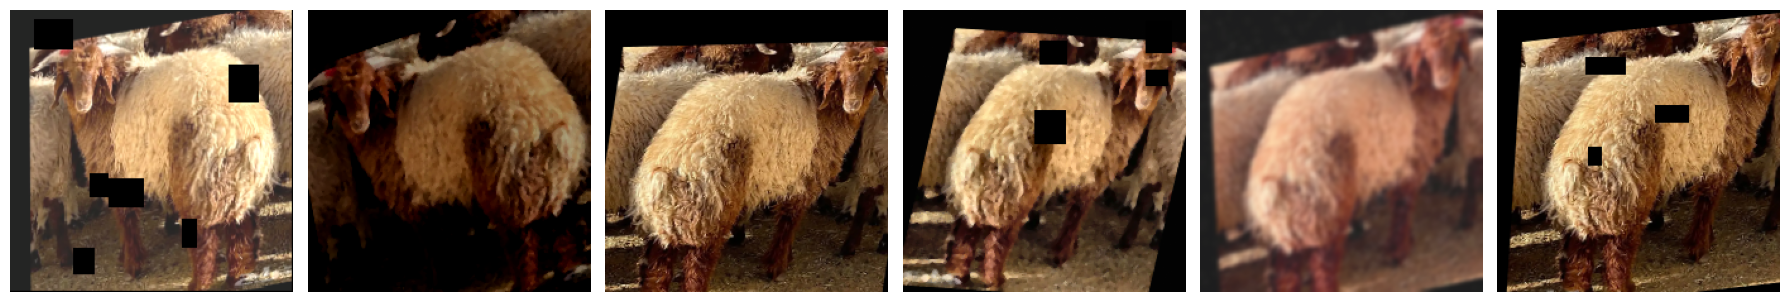

In [11]:
plot_augmented_samples("/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train/0048b660.jpg")

### 3.2.2 Class Weights


To further tackle imbalance, we define a function `compute_class_weights()` that computes a weight for each class based on its frequency in the dataset


This technique ensures:
- Minority classes are assigned higher weights
- Majority classes get lower weights

These weights are passed to the loss function so the model pays more attention to underrepresented classes. This way, incorrect predictions on rare classes are penalized more, helping the model not just favor the "popular" ones.

In [12]:
# ======================
# Data Loading
# ======================

# Load the training data
train_df = pd.read_csv(CONFIG.train_csv)

label2idx, idx2label = get_label_maps()

# Map labels to indices
train_df["label"] = train_df["label"].map(label2idx)
display(train_df)

filename  label
0    39d30b68.jpg      3
1    4a9853bd.jpg      1
2    d88facaa.jpg      5
3    a3f4f4af.jpg      5
4    16b31730.jpg      3
..            ...    ...
677  2c0ea8a4.jpg      3
678  fc48f9e0.jpg      1
679  4baa1e02.jpg      3
680  8c0907bc.jpg      3
681  f47dfc80.jpg      4

[682 rows x 2 columns]

In [13]:
# Compute class weights
class_weights = compute_class_weights(train_df["label"].values, method="effective").to(CONFIG.device)
print(class_weights)

tensor([2.0280, 0.6658, 1.1464, 0.2814, 1.0015, 0.9877, 0.8892],
       device='cuda:0')


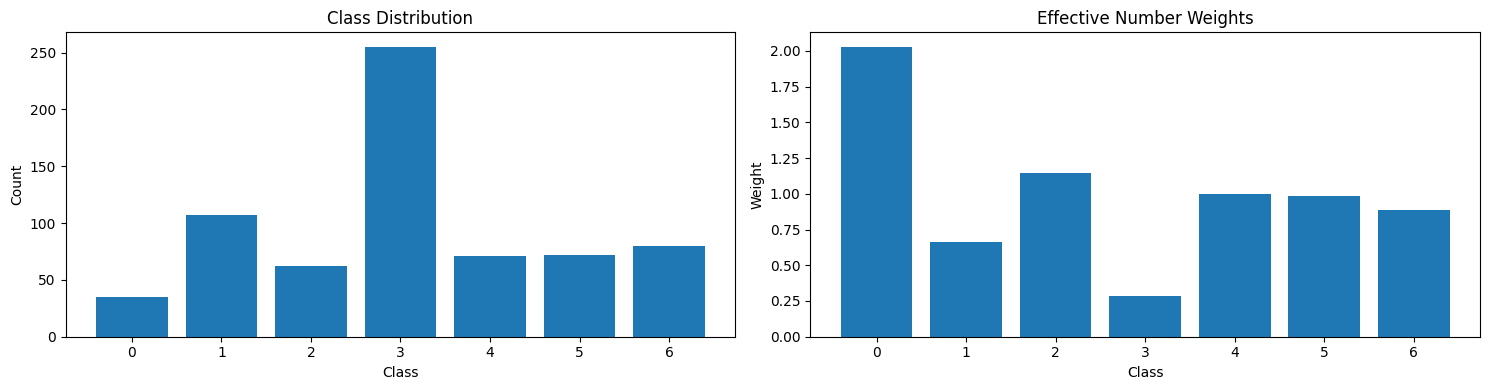

In [14]:
# Plot class distribution and effective weights
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Class distribution
counts = np.bincount(train_df["label"].values)
ax1.bar(range(len(counts)), counts)
ax1.set_title("Class Distribution")
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")

# Class weights
ax2.bar(range(len(class_weights)), class_weights.cpu().numpy())
ax2.set_title("Effective Number Weights")
ax2.set_xlabel("Class")
ax2.set_ylabel("Weight")

plt.tight_layout()
plt.show()

tensor([2.7837, 0.9105, 1.5714, 0.3821, 1.3722, 1.3532, 1.2179],
       device='cuda:0')


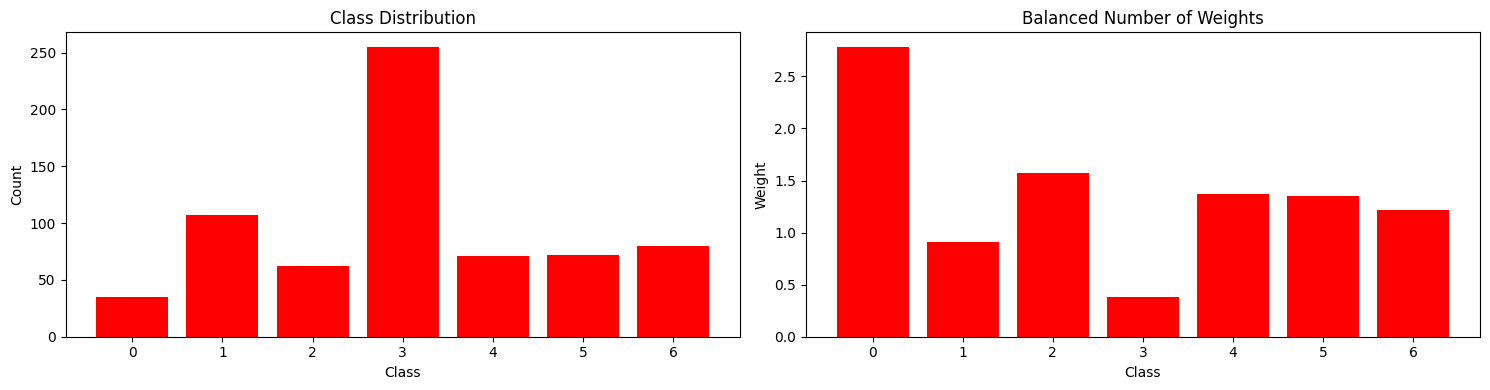

In [15]:
# computing weights using sklearn’s built-in class weight computation based on inverse class frequency
# we are not using this method, but it's good to know about it
_class_weights = compute_class_weights(train_df["label"].values, method="balanced").to(CONFIG.device)
print(_class_weights)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Class distribution
counts = np.bincount(train_df["label"].values)
ax1.bar(range(len(counts)), counts, color="red")
ax1.set_title("Class Distribution")
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")

# Class weights
ax2.bar(range(len(_class_weights)), _class_weights.cpu().numpy(), color="red")
ax2.set_title("Balanced Number of Weights")
ax2.set_xlabel("Class")
ax2.set_ylabel("Weight")

plt.tight_layout()
plt.show()

# delete the unused variable
del _class_weights

We will use the `effective` method as it uses the **effective number of samples** technique, which better adjusts weights in highly imbalanced datasets by discounting the impact of abundant classes. However as you can see there isn't much of a difference between them

### 3.3 Model Architecture

Our model is built around a powerful Vision Transformer (ViT) backbone. Specifically, we use the `vit_base_patch16_224.augreg_in21k_ft_in1k` variant from the [*An Image is Worth 16x16 Words*](https://arxiv.org/pdf/2010.11929), and creating it using [timm](https://huggingface.co/timm/vit_base_patch16_224.augreg_in21k_ft_in1k)

This version was trained on a large-scale ImageNet-21k dataset and fine-tuned on ImageNet-1k using strong data augmentation and regularization techniques (`augreg` = augmentation + regularization). That gives us a strong starting point.

ViT works by splitting an image into small patches (16×16 in our case), flattening them, and passing them through a standard transformer encoder — just like how transformers process text. This allows the model to capture both local and global context effectively


To adapt it to our classification task:
- We remove the original classification head.
- We add a custom MLP head (Multi-Layer Perceptron) with dropout and batch normalization, which helps the model generalize better and stay stable

In [16]:
model = ViTClassifier(CONFIG.model_name, CONFIG.num_classes).to(CONFIG.device)
summary(model, (3, CONFIG.img_size, CONFIG.img_size))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

## 3.4 Loss Function

While `CrossEntropyLoss` is the standard go-to for classification tasks, it doesn’t always hold up well when there’s class imbalance, and that’s exactly where Focal Loss comes in to save the day

**Cross-Entropy Loss Recap:**

- For a single binary classification sample, the cross-entropy loss is:
  <center>
    $
    CE(p,y)=−ylog(p)−(1−y)log(1−p)
    $
  </center>

    Where
  
  - $y$ is the true label (0 or 1)
  - $p$ is the predicted probability of class 1

<br>

- For multi-class classification, it generalizes to:
  <center>
    $
    CE(pt​)=−log(pt​)
    $
  </center>

    Where $pt$​ is the predicted probability for the correct class.

    The problem? Standard cross-entropy treats all errors equally. If the model is very confident but wrong about an easy (majority) sample, or slightly wrong about a hard (minority) sample, the loss contributions are not differentiated well enough. Easy samples (majority classes) quickly become well-classified and contribute little to the loss, but they still dominate the total loss because there are so many of them. This means the model doesn't get enough "signal" to learn from the hard (minority) examples.

**Focal Loss:** 

- Focal loss modifies the cross-entropy loss by adding a **modulating factor** $(1−pt​)γ$ to it.
  <center>
    $
    FL(pt​)=−(1−pt​)^γlog(pt​)
    $
  </center>

    Where:

    - $pt$​ is the probability of the true class.

    - $γ (gamma)$ is a focusing parameter ($γ≥0$).

- We can also add an $α$ (alpha) **balancing factor** to give different importance to each class:

  <center>
  $FL(pt​)=−αt​(1−pt​)γlog(pt​)$
  </center>
  <br>
  In our implementation, we pass `class_weights` to `self.alpha`, so it handles both class imbalance and hard example mining at the same time, so our `FocalLoss` also accepts a weights parameter in its forward method, letting us apply extra confidence based weighting when needed (like during pseudo-labeling). This way, we get the best of both worlds, handling class imbalance and adjusting for how confident each prediction is

## 3.5 Optimizers and Schedulers

Optimizers and learning rate schedulers are the engine that drives deep learning training. They decide how to update the model’s weights based on the loss to get better and better predictions


We use [AdamW](https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html) which is a modern upgrade to Adam. It separates weight decay from the gradient steps, helping the model generalize better and avoid overfitting

Since our model has two main parts (the pre-trained Vision Transformer backbone and the fresh classification head), we treat them differently:

- The **backbone** gets a **smaller learning rate** because it already knows a lot and just needs fine-tuning
- The **classifier head** gets a **larger learning rate** because it starts from scratch and needs to learn faster

On top of that, we use a `CosineAnnealingWarmRestarts` scheduler, which periodically restarts the learning rate in a cosine pattern. This helps the model avoid getting stuck in local minima and converge more smoothly

# 4. Initial Cross-Validation Training

PHASE 1: Initial Cross-Validation Training

====================================================================== FOLD 1 ======================================================================
Train distribution: [28, 85, 49, 204, 57, 58, 64], Length: 545
Val distribution: [7, 22, 13, 51, 14, 14, 16], Length: 137


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.24it/s]


Fold 1 | Epoch 1 | Train Loss: 0.7604 | Train Acc: 0.3768 | Val Loss: 0.1356 | Val Acc: 0.7664 | Val F1 Macro: 0.7798 | Val F1 Weighted: 0.7618
New best F1-macro for Fold 1 at epoch 1. Model saved. Current Best F1-macro: 0.7798


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.79it/s]


Fold 1 | Epoch 2 | Train Loss: 0.2063 | Train Acc: 0.7445 | Val Loss: 0.0883 | Val Acc: 0.8905 | Val F1 Macro: 0.8931 | Val F1 Weighted: 0.8902
New best F1-macro for Fold 1 at epoch 2. Model saved. Current Best F1-macro: 0.8931


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.94it/s]


Fold 1 | Epoch 3 | Train Loss: 0.1293 | Train Acc: 0.8143 | Val Loss: 0.0737 | Val Acc: 0.8978 | Val F1 Macro: 0.8961 | Val F1 Weighted: 0.8989
New best F1-macro for Fold 1 at epoch 3. Model saved. Current Best F1-macro: 0.8961


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.96it/s]


Fold 1 | Epoch 4 | Train Loss: 0.0948 | Train Acc: 0.8805 | Val Loss: 0.0851 | Val Acc: 0.9343 | Val F1 Macro: 0.9331 | Val F1 Weighted: 0.9355
New best F1-macro for Fold 1 at epoch 4. Model saved. Current Best F1-macro: 0.9331


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.81it/s]


Fold 1 | Epoch 5 | Train Loss: 0.0672 | Train Acc: 0.9191 | Val Loss: 0.1010 | Val Acc: 0.9343 | Val F1 Macro: 0.9299 | Val F1 Weighted: 0.9354


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.95it/s]


Fold 1 | Epoch 6 | Train Loss: 0.0351 | Train Acc: 0.9522 | Val Loss: 0.0989 | Val Acc: 0.9416 | Val F1 Macro: 0.9316 | Val F1 Weighted: 0.9436


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.87it/s]


Fold 1 | Epoch 7 | Train Loss: 0.0447 | Train Acc: 0.9375 | Val Loss: 0.0598 | Val Acc: 0.9343 | Val F1 Macro: 0.9320 | Val F1 Weighted: 0.9353


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.78it/s]


Fold 1 | Epoch 8 | Train Loss: 0.0155 | Train Acc: 0.9743 | Val Loss: 0.0737 | Val Acc: 0.9343 | Val F1 Macro: 0.9320 | Val F1 Weighted: 0.9353


Validating: 100%|██████████| 18/18 [00:01<00:00, 15.00it/s]


Fold 1 | Epoch 9 | Train Loss: 0.0297 | Train Acc: 0.9540 | Val Loss: 0.0715 | Val Acc: 0.9343 | Val F1 Macro: 0.9320 | Val F1 Weighted: 0.9353
Early stopping at epoch 9

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     0.9091    0.9091    0.9091        22
           2     0.8000    0.9231    0.8571        13
           3     1.0000    0.9216    0.9592        51
           4     1.0000    1.0000    1.0000        14
           5     0.8235    1.0000    0.9032        14
           6     0.9333    0.8750    0.9032        16

    accuracy                         0.9343       137
   macro avg     0.9237    0.9470    0.9331       137
weighted avg     0.9406    0.9343    0.9355       137


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 20  1  0  0  0  1]
 [ 0  0 12  0  0  1  0]
 [ 0  2  0 47  0  2  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0 14  0]
 [ 0  0  2  0  0  0 14]]

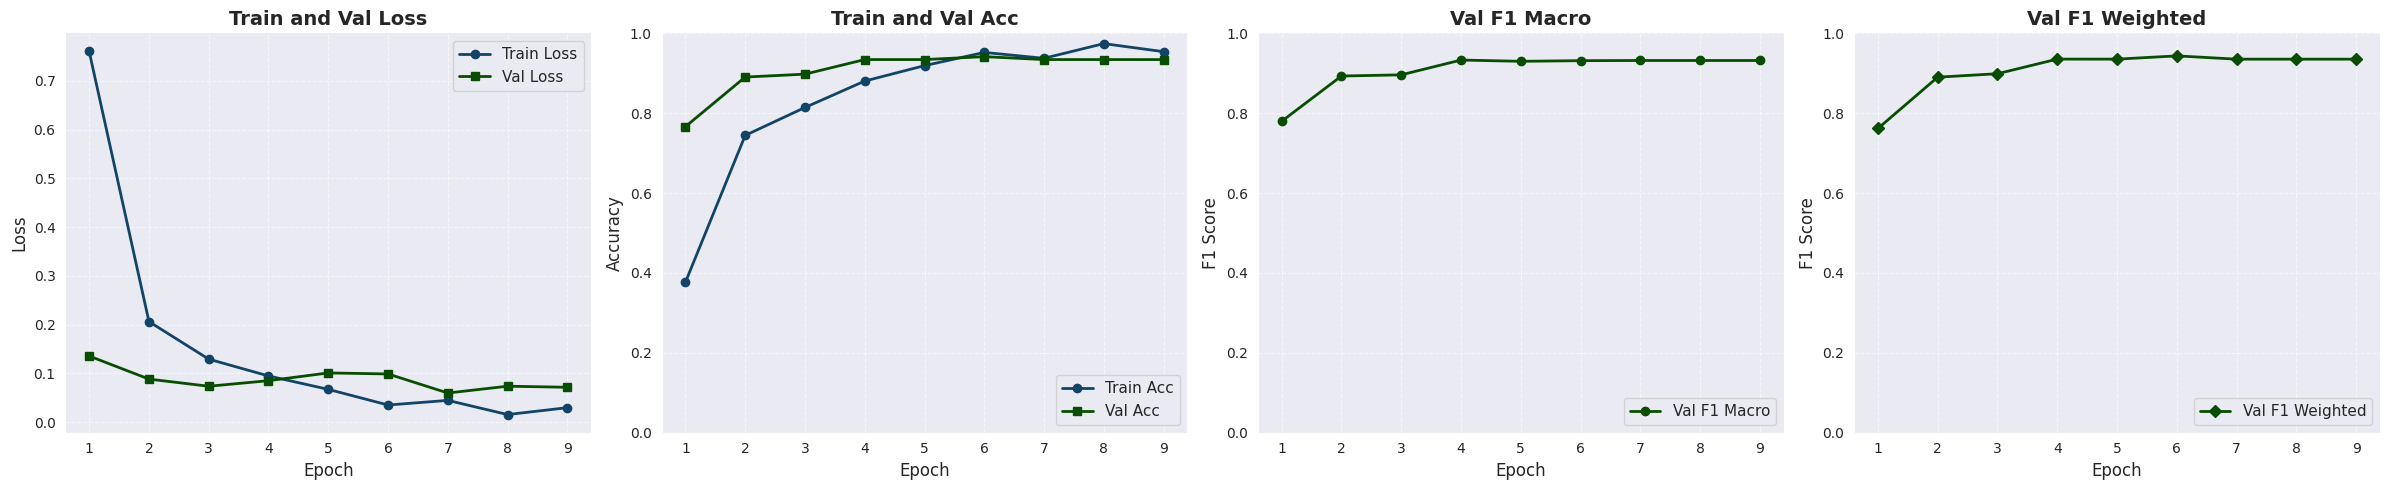


Fold 1 best F1: 0.9331

====================================================================== FOLD 2 ======================================================================
Train distribution: [28, 85, 50, 204, 56, 58, 64], Length: 545
Val distribution: [7, 22, 12, 51, 15, 14, 16], Length: 137


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.61it/s]


Fold 2 | Epoch 1 | Train Loss: 0.7239 | Train Acc: 0.4651 | Val Loss: 0.2115 | Val Acc: 0.7810 | Val F1 Macro: 0.7424 | Val F1 Weighted: 0.7829
New best F1-macro for Fold 2 at epoch 1. Model saved. Current Best F1-macro: 0.7424


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.68it/s]


Fold 2 | Epoch 2 | Train Loss: 0.1805 | Train Acc: 0.7592 | Val Loss: 0.1707 | Val Acc: 0.8613 | Val F1 Macro: 0.8328 | Val F1 Weighted: 0.8637
New best F1-macro for Fold 2 at epoch 2. Model saved. Current Best F1-macro: 0.8328


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.44it/s]


Fold 2 | Epoch 3 | Train Loss: 0.1248 | Train Acc: 0.8382 | Val Loss: 0.1589 | Val Acc: 0.8613 | Val F1 Macro: 0.8265 | Val F1 Weighted: 0.8655


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.44it/s]


Fold 2 | Epoch 4 | Train Loss: 0.1141 | Train Acc: 0.8658 | Val Loss: 0.1138 | Val Acc: 0.8686 | Val F1 Macro: 0.8434 | Val F1 Weighted: 0.8715
New best F1-macro for Fold 2 at epoch 4. Model saved. Current Best F1-macro: 0.8434


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.44it/s]


Fold 2 | Epoch 5 | Train Loss: 0.0770 | Train Acc: 0.9026 | Val Loss: 0.1105 | Val Acc: 0.9416 | Val F1 Macro: 0.9195 | Val F1 Weighted: 0.9418
New best F1-macro for Fold 2 at epoch 5. Model saved. Current Best F1-macro: 0.9195


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.10it/s]


Fold 2 | Epoch 6 | Train Loss: 0.0360 | Train Acc: 0.9393 | Val Loss: 0.1024 | Val Acc: 0.9489 | Val F1 Macro: 0.9265 | Val F1 Weighted: 0.9495
New best F1-macro for Fold 2 at epoch 6. Model saved. Current Best F1-macro: 0.9265


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.55it/s]


Fold 2 | Epoch 7 | Train Loss: 0.0245 | Train Acc: 0.9577 | Val Loss: 0.1064 | Val Acc: 0.9562 | Val F1 Macro: 0.9377 | Val F1 Weighted: 0.9562
New best F1-macro for Fold 2 at epoch 7. Model saved. Current Best F1-macro: 0.9377


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.57it/s]


Fold 2 | Epoch 8 | Train Loss: 0.0264 | Train Acc: 0.9577 | Val Loss: 0.0993 | Val Acc: 0.9489 | Val F1 Macro: 0.9314 | Val F1 Weighted: 0.9490


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.57it/s]


Fold 2 | Epoch 9 | Train Loss: 0.0293 | Train Acc: 0.9577 | Val Loss: 0.1129 | Val Acc: 0.9489 | Val F1 Macro: 0.9296 | Val F1 Weighted: 0.9484


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.59it/s]


Fold 2 | Epoch 10 | Train Loss: 0.0162 | Train Acc: 0.9724 | Val Loss: 0.1382 | Val Acc: 0.9270 | Val F1 Macro: 0.8972 | Val F1 Weighted: 0.9270


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.17it/s]


Fold 2 | Epoch 11 | Train Loss: 0.0171 | Train Acc: 0.9559 | Val Loss: 0.0897 | Val Acc: 0.9343 | Val F1 Macro: 0.9137 | Val F1 Weighted: 0.9345


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.77it/s]


Fold 2 | Epoch 12 | Train Loss: 0.0132 | Train Acc: 0.9816 | Val Loss: 0.0990 | Val Acc: 0.9343 | Val F1 Macro: 0.9144 | Val F1 Weighted: 0.9341
Early stopping at epoch 12

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.8571    0.8571    0.8571         7
           1     0.9500    0.8636    0.9048        22
           2     0.8000    1.0000    0.8889        12
           3     0.9808    1.0000    0.9903        51
           4     1.0000    1.0000    1.0000        15
           5     1.0000    0.8571    0.9231        14
           6     1.0000    1.0000    1.0000        16

    accuracy                         0.9562       137
   macro avg     0.9411    0.9397    0.9377       137
weighted avg     0.9600    0.9562    0.9562       137


----- Confusion Matrix -----
[[ 6  1  0  0  0  0  0]
 [ 1 19  2  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 51  0  0  0]
 [ 0  0  0  0 15  0  0]
 [ 0  0  1  1  0 12  0]
 [ 0  0  0  0  0  0 16

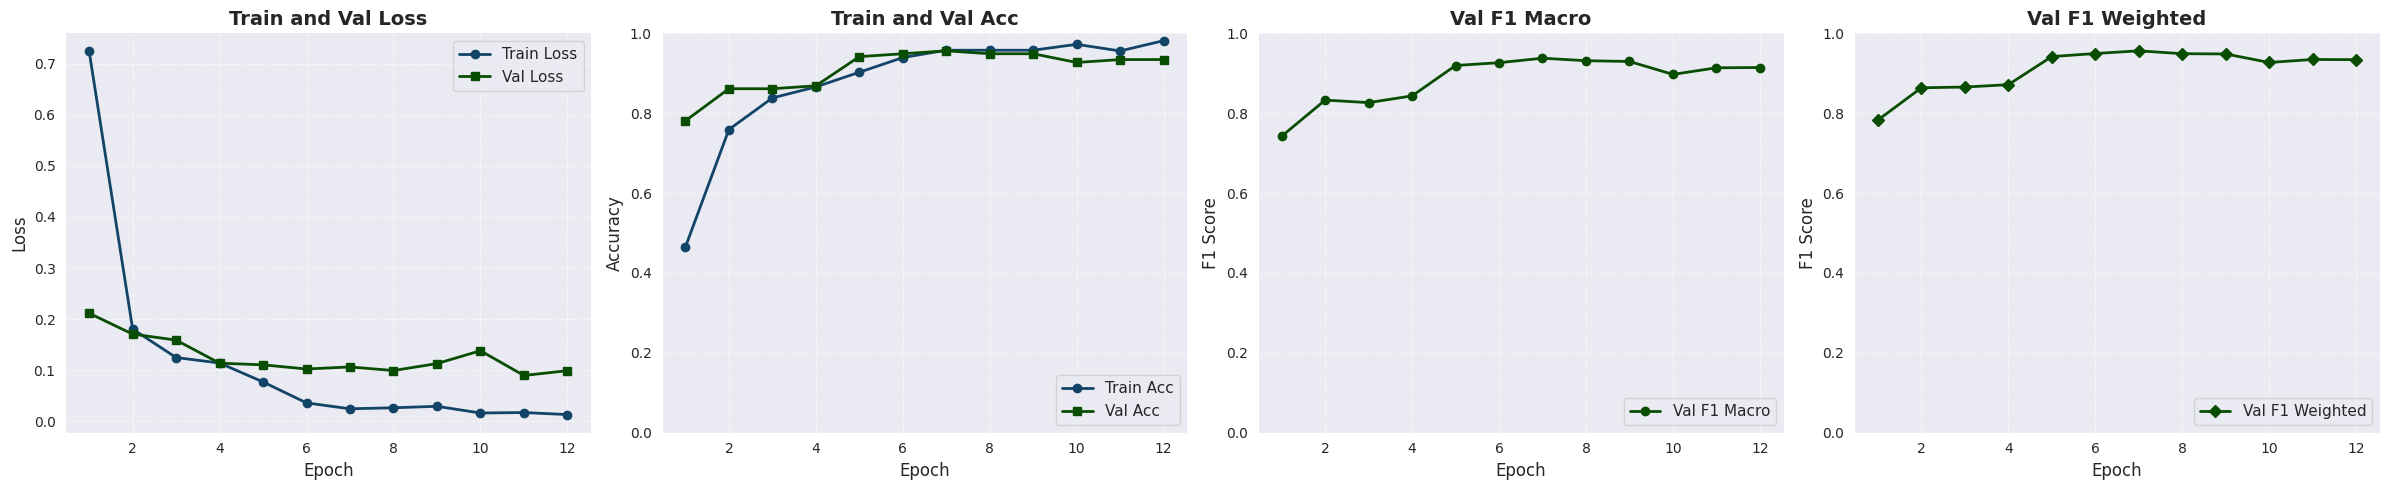


Fold 2 best F1: 0.9377

====================================================================== FOLD 3 ======================================================================
Train distribution: [28, 86, 50, 204, 57, 57, 64], Length: 546
Val distribution: [7, 21, 12, 51, 14, 15, 16], Length: 136


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.54it/s]


Fold 3 | Epoch 1 | Train Loss: 0.7871 | Train Acc: 0.3989 | Val Loss: 0.2170 | Val Acc: 0.8162 | Val F1 Macro: 0.7695 | Val F1 Weighted: 0.8125
New best F1-macro for Fold 3 at epoch 1. Model saved. Current Best F1-macro: 0.7695


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.60it/s]


Fold 3 | Epoch 2 | Train Loss: 0.2076 | Train Acc: 0.7390 | Val Loss: 0.1397 | Val Acc: 0.8897 | Val F1 Macro: 0.8802 | Val F1 Weighted: 0.8870
New best F1-macro for Fold 3 at epoch 2. Model saved. Current Best F1-macro: 0.8802


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.35it/s]


Fold 3 | Epoch 3 | Train Loss: 0.1205 | Train Acc: 0.8033 | Val Loss: 0.1310 | Val Acc: 0.8897 | Val F1 Macro: 0.8845 | Val F1 Weighted: 0.8864
New best F1-macro for Fold 3 at epoch 3. Model saved. Current Best F1-macro: 0.8845


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


Fold 3 | Epoch 4 | Train Loss: 0.1618 | Train Acc: 0.8309 | Val Loss: 0.1657 | Val Acc: 0.8897 | Val F1 Macro: 0.8644 | Val F1 Weighted: 0.8857


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.73it/s]


Fold 3 | Epoch 5 | Train Loss: 0.1138 | Train Acc: 0.8787 | Val Loss: 0.1546 | Val Acc: 0.9412 | Val F1 Macro: 0.9281 | Val F1 Weighted: 0.9398
New best F1-macro for Fold 3 at epoch 5. Model saved. Current Best F1-macro: 0.9281


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.23it/s]


Fold 3 | Epoch 6 | Train Loss: 0.0523 | Train Acc: 0.9191 | Val Loss: 0.1429 | Val Acc: 0.9338 | Val F1 Macro: 0.9274 | Val F1 Weighted: 0.9335


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.36it/s]


Fold 3 | Epoch 7 | Train Loss: 0.0196 | Train Acc: 0.9632 | Val Loss: 0.1537 | Val Acc: 0.9412 | Val F1 Macro: 0.9266 | Val F1 Weighted: 0.9401


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.27it/s]


Fold 3 | Epoch 8 | Train Loss: 0.0106 | Train Acc: 0.9632 | Val Loss: 0.1493 | Val Acc: 0.9485 | Val F1 Macro: 0.9369 | Val F1 Weighted: 0.9474
New best F1-macro for Fold 3 at epoch 8. Model saved. Current Best F1-macro: 0.9369


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.44it/s]


Fold 3 | Epoch 9 | Train Loss: 0.0182 | Train Acc: 0.9504 | Val Loss: 0.1594 | Val Acc: 0.9485 | Val F1 Macro: 0.9404 | Val F1 Weighted: 0.9479
New best F1-macro for Fold 3 at epoch 9. Model saved. Current Best F1-macro: 0.9404


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.32it/s]


Fold 3 | Epoch 10 | Train Loss: 0.0429 | Train Acc: 0.9283 | Val Loss: 0.1294 | Val Acc: 0.9118 | Val F1 Macro: 0.9019 | Val F1 Weighted: 0.9100


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.45it/s]


Fold 3 | Epoch 11 | Train Loss: 0.0652 | Train Acc: 0.9540 | Val Loss: 0.1515 | Val Acc: 0.9191 | Val F1 Macro: 0.9036 | Val F1 Weighted: 0.9205


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.34it/s]


Fold 3 | Epoch 12 | Train Loss: 0.0129 | Train Acc: 0.9559 | Val Loss: 0.2310 | Val Acc: 0.9191 | Val F1 Macro: 0.8923 | Val F1 Weighted: 0.9111


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.49it/s]


Fold 3 | Epoch 13 | Train Loss: 0.0277 | Train Acc: 0.9688 | Val Loss: 0.2432 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9381


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]


Fold 3 | Epoch 14 | Train Loss: 0.0138 | Train Acc: 0.9816 | Val Loss: 0.2174 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9381
Early stopping at epoch 14

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.8750    1.0000    0.9333         7
           1     0.9091    0.9524    0.9302        21
           2     1.0000    0.9167    0.9565        12
           3     0.9615    0.9804    0.9709        51
           4     0.9333    1.0000    0.9655        14
           5     1.0000    0.8000    0.8889        15
           6     0.9375    0.9375    0.9375        16

    accuracy                         0.9485       136
   macro avg     0.9452    0.9410    0.9404       136
weighted avg     0.9509    0.9485    0.9479       136


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 20  0  0  1  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  1  0 50  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  2  0 12  1]
 [ 0  1  0  0  0  0 15

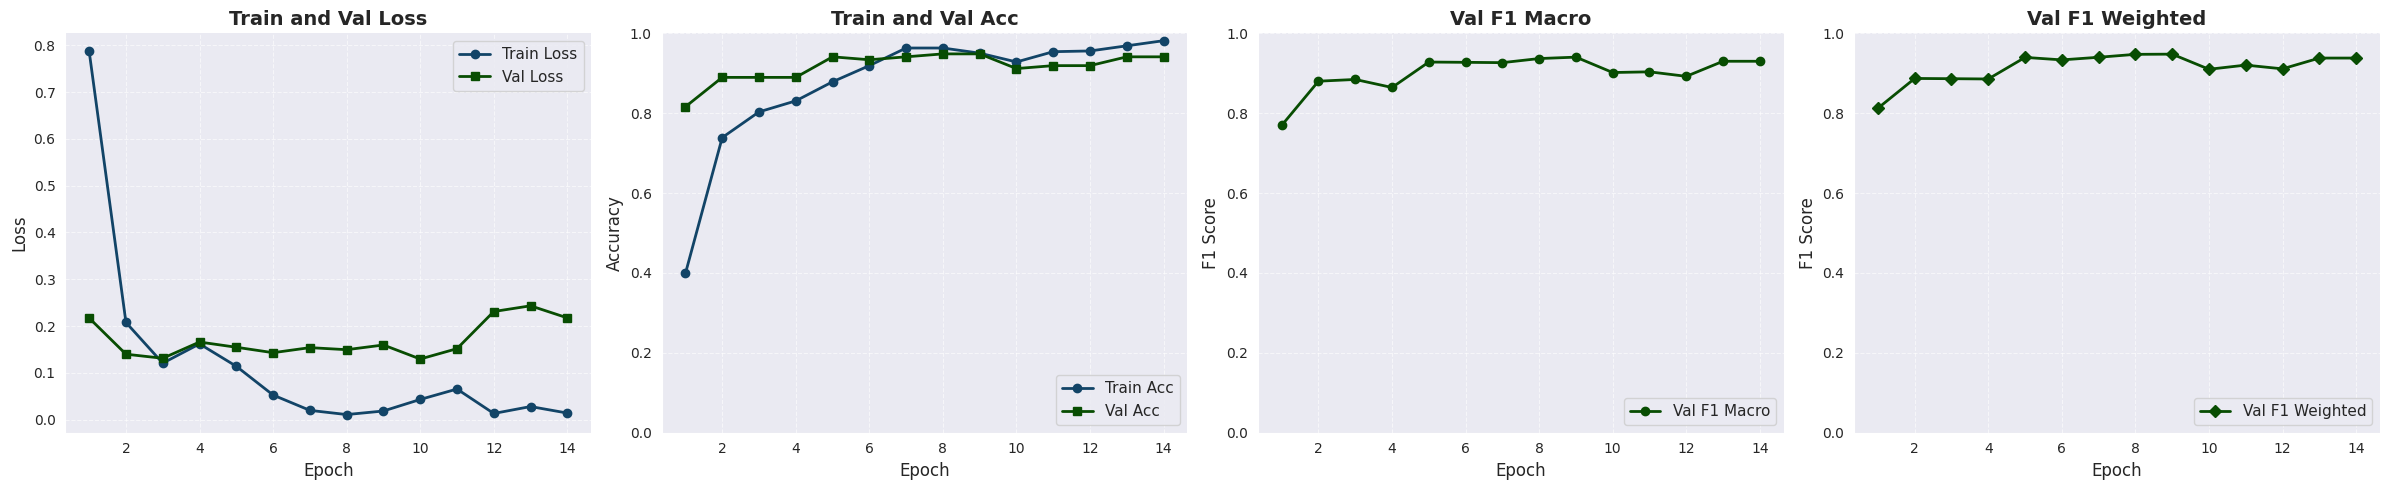


Fold 3 best F1: 0.9404

====================================================================== FOLD 4 ======================================================================
Train distribution: [28, 86, 50, 204, 57, 57, 64], Length: 546
Val distribution: [7, 21, 12, 51, 14, 15, 16], Length: 136


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.48it/s]


Fold 4 | Epoch 1 | Train Loss: 0.7842 | Train Acc: 0.3934 | Val Loss: 0.1074 | Val Acc: 0.8088 | Val F1 Macro: 0.8078 | Val F1 Weighted: 0.8154
New best F1-macro for Fold 4 at epoch 1. Model saved. Current Best F1-macro: 0.8078


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.24it/s]


Fold 4 | Epoch 2 | Train Loss: 0.1978 | Train Acc: 0.7040 | Val Loss: 0.0654 | Val Acc: 0.8971 | Val F1 Macro: 0.8864 | Val F1 Weighted: 0.8990
New best F1-macro for Fold 4 at epoch 2. Model saved. Current Best F1-macro: 0.8864


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.46it/s]


Fold 4 | Epoch 3 | Train Loss: 0.1554 | Train Acc: 0.8143 | Val Loss: 0.0509 | Val Acc: 0.9265 | Val F1 Macro: 0.9282 | Val F1 Weighted: 0.9285
New best F1-macro for Fold 4 at epoch 3. Model saved. Current Best F1-macro: 0.9282


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.47it/s]


Fold 4 | Epoch 4 | Train Loss: 0.1319 | Train Acc: 0.8529 | Val Loss: 0.0525 | Val Acc: 0.9191 | Val F1 Macro: 0.9261 | Val F1 Weighted: 0.9209


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.37it/s]


Fold 4 | Epoch 5 | Train Loss: 0.1085 | Train Acc: 0.9007 | Val Loss: 0.0385 | Val Acc: 0.9706 | Val F1 Macro: 0.9754 | Val F1 Weighted: 0.9706
New best F1-macro for Fold 4 at epoch 5. Model saved. Current Best F1-macro: 0.9754


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.12it/s]


Fold 4 | Epoch 6 | Train Loss: 0.0424 | Train Acc: 0.9485 | Val Loss: 0.0492 | Val Acc: 0.9632 | Val F1 Macro: 0.9657 | Val F1 Weighted: 0.9625


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.48it/s]


Fold 4 | Epoch 7 | Train Loss: 0.0463 | Train Acc: 0.9430 | Val Loss: 0.0493 | Val Acc: 0.9779 | Val F1 Macro: 0.9811 | Val F1 Weighted: 0.9777
New best F1-macro for Fold 4 at epoch 7. Model saved. Current Best F1-macro: 0.9811


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.10it/s]


Fold 4 | Epoch 8 | Train Loss: 0.0392 | Train Acc: 0.9504 | Val Loss: 0.0638 | Val Acc: 0.9706 | Val F1 Macro: 0.9741 | Val F1 Weighted: 0.9698


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.47it/s]


Fold 4 | Epoch 9 | Train Loss: 0.0217 | Train Acc: 0.9706 | Val Loss: 0.0493 | Val Acc: 0.9779 | Val F1 Macro: 0.9811 | Val F1 Weighted: 0.9777


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.39it/s]


Fold 4 | Epoch 10 | Train Loss: 0.0218 | Train Acc: 0.9651 | Val Loss: 0.0779 | Val Acc: 0.9559 | Val F1 Macro: 0.9574 | Val F1 Weighted: 0.9552


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


Fold 4 | Epoch 11 | Train Loss: 0.0250 | Train Acc: 0.9651 | Val Loss: 0.0495 | Val Acc: 0.9779 | Val F1 Macro: 0.9786 | Val F1 Weighted: 0.9776


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.32it/s]


Fold 4 | Epoch 12 | Train Loss: 0.0389 | Train Acc: 0.9651 | Val Loss: 0.0500 | Val Acc: 0.9779 | Val F1 Macro: 0.9771 | Val F1 Weighted: 0.9770
Early stopping at epoch 12

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000        21
           2     1.0000    1.0000    1.0000        12
           3     0.9615    0.9804    0.9709        51
           4     1.0000    1.0000    1.0000        14
           5     0.9286    0.8667    0.8966        15
           6     1.0000    1.0000    1.0000        16

    accuracy                         0.9779       136
   macro avg     0.9843    0.9782    0.9811       136
weighted avg     0.9777    0.9779    0.9777       136


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 50  0  1  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  2  0 13  0]
 [ 0  0  0  0  0  0 16

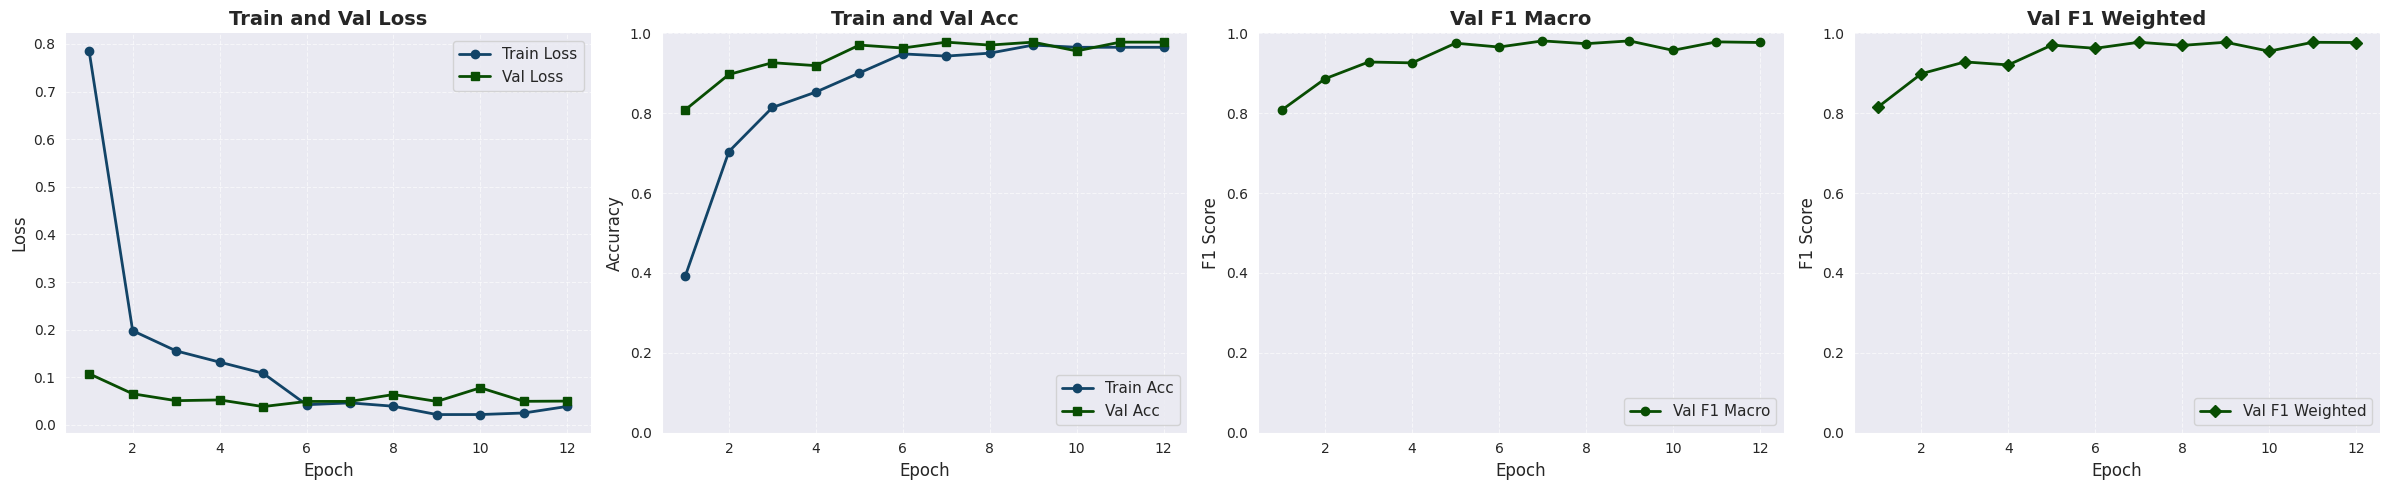


Fold 4 best F1: 0.9811

====================================================================== FOLD 5 ======================================================================
Train distribution: [28, 86, 49, 204, 57, 58, 64], Length: 546
Val distribution: [7, 21, 13, 51, 14, 14, 16], Length: 136


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.66it/s]


Fold 5 | Epoch 1 | Train Loss: 0.7081 | Train Acc: 0.4007 | Val Loss: 0.1276 | Val Acc: 0.8088 | Val F1 Macro: 0.7996 | Val F1 Weighted: 0.8124
New best F1-macro for Fold 5 at epoch 1. Model saved. Current Best F1-macro: 0.7996


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.72it/s]


Fold 5 | Epoch 2 | Train Loss: 0.2267 | Train Acc: 0.7004 | Val Loss: 0.0797 | Val Acc: 0.9191 | Val F1 Macro: 0.9064 | Val F1 Weighted: 0.9200
New best F1-macro for Fold 5 at epoch 2. Model saved. Current Best F1-macro: 0.9064


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.74it/s]


Fold 5 | Epoch 3 | Train Loss: 0.1253 | Train Acc: 0.8125 | Val Loss: 0.0659 | Val Acc: 0.9044 | Val F1 Macro: 0.8958 | Val F1 Weighted: 0.9061


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.77it/s]


Fold 5 | Epoch 4 | Train Loss: 0.1518 | Train Acc: 0.8107 | Val Loss: 0.0424 | Val Acc: 0.9191 | Val F1 Macro: 0.9157 | Val F1 Weighted: 0.9212
New best F1-macro for Fold 5 at epoch 4. Model saved. Current Best F1-macro: 0.9157


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.76it/s]


Fold 5 | Epoch 5 | Train Loss: 0.0669 | Train Acc: 0.9044 | Val Loss: 0.0195 | Val Acc: 0.9632 | Val F1 Macro: 0.9607 | Val F1 Weighted: 0.9626
New best F1-macro for Fold 5 at epoch 5. Model saved. Current Best F1-macro: 0.9607


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.90it/s]


Fold 5 | Epoch 6 | Train Loss: 0.0457 | Train Acc: 0.9393 | Val Loss: 0.0226 | Val Acc: 0.9779 | Val F1 Macro: 0.9728 | Val F1 Weighted: 0.9778
New best F1-macro for Fold 5 at epoch 6. Model saved. Current Best F1-macro: 0.9728


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.83it/s]


Fold 5 | Epoch 7 | Train Loss: 0.0337 | Train Acc: 0.9485 | Val Loss: 0.0179 | Val Acc: 0.9779 | Val F1 Macro: 0.9779 | Val F1 Weighted: 0.9778
New best F1-macro for Fold 5 at epoch 7. Model saved. Current Best F1-macro: 0.9779


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.89it/s]


Fold 5 | Epoch 8 | Train Loss: 0.0265 | Train Acc: 0.9522 | Val Loss: 0.0151 | Val Acc: 0.9853 | Val F1 Macro: 0.9823 | Val F1 Weighted: 0.9849
New best F1-macro for Fold 5 at epoch 8. Model saved. Current Best F1-macro: 0.9823


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.90it/s]


Fold 5 | Epoch 9 | Train Loss: 0.0285 | Train Acc: 0.9779 | Val Loss: 0.0128 | Val Acc: 0.9853 | Val F1 Macro: 0.9824 | Val F1 Weighted: 0.9854
New best F1-macro for Fold 5 at epoch 9. Model saved. Current Best F1-macro: 0.9824


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.95it/s]


Fold 5 | Epoch 10 | Train Loss: 0.0432 | Train Acc: 0.9375 | Val Loss: 0.0149 | Val Acc: 0.9926 | Val F1 Macro: 0.9933 | Val F1 Weighted: 0.9925
New best F1-macro for Fold 5 at epoch 10. Model saved. Current Best F1-macro: 0.9933


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.94it/s]


Fold 5 | Epoch 11 | Train Loss: 0.0311 | Train Acc: 0.9559 | Val Loss: 0.0345 | Val Acc: 0.9779 | Val F1 Macro: 0.9742 | Val F1 Weighted: 0.9777


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.83it/s]


Fold 5 | Epoch 12 | Train Loss: 0.0371 | Train Acc: 0.9669 | Val Loss: 0.0304 | Val Acc: 0.9779 | Val F1 Macro: 0.9679 | Val F1 Weighted: 0.9781


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.89it/s]


Fold 5 | Epoch 13 | Train Loss: 0.0238 | Train Acc: 0.9724 | Val Loss: 0.0229 | Val Acc: 0.9779 | Val F1 Macro: 0.9779 | Val F1 Weighted: 0.9778


Validating: 100%|██████████| 17/17 [00:01<00:00, 14.00it/s]


Fold 5 | Epoch 14 | Train Loss: 0.0364 | Train Acc: 0.9596 | Val Loss: 0.0080 | Val Acc: 0.9926 | Val F1 Macro: 0.9933 | Val F1 Weighted: 0.9925


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.67it/s]


Fold 5 | Epoch 15 | Train Loss: 0.0175 | Train Acc: 0.9688 | Val Loss: 0.0063 | Val Acc: 0.9853 | Val F1 Macro: 0.9885 | Val F1 Weighted: 0.9852
Early stopping at epoch 15

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000        21
           2     1.0000    1.0000    1.0000        13
           3     0.9808    1.0000    0.9903        51
           4     1.0000    1.0000    1.0000        14
           5     1.0000    0.9286    0.9630        14
           6     1.0000    1.0000    1.0000        16

    accuracy                         0.9926       136
   macro avg     0.9973    0.9898    0.9933       136
weighted avg     0.9928    0.9926    0.9925       136


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 0  0 13  0  0  0  0]
 [ 0  0  0 51  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  1  0 13  0]
 [ 0  0  0  0  0  0 16

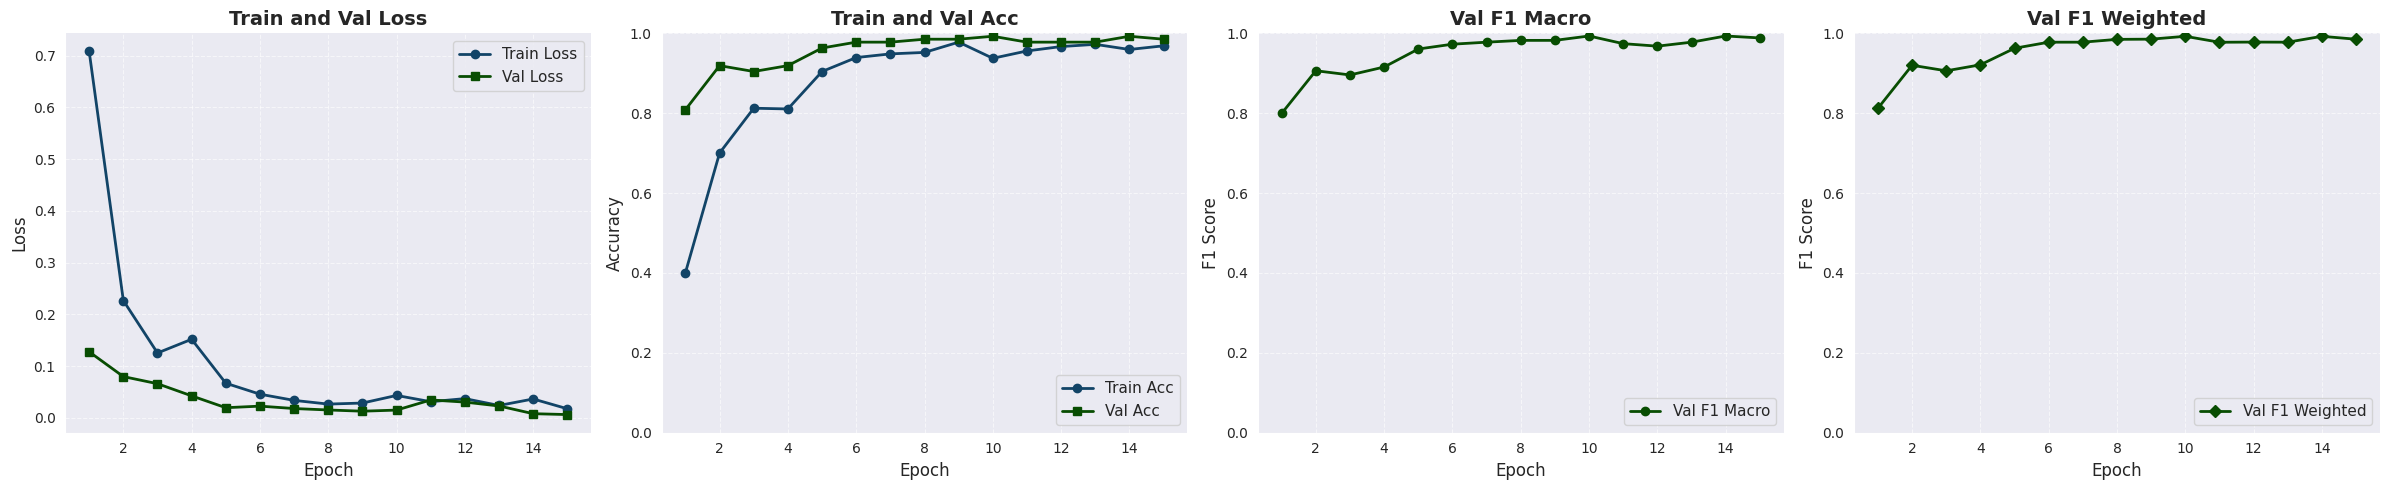


Fold 5 best F1: 0.9933

Cross-validation results:
Mean F1: 0.9571 ± 0.0250
Individual fold scores: [0.93312415037234, 0.9377374051437852, 0.9404096496113242, 0.9810607872208139, 0.9933220321569837]


In [17]:
# ======================
# Cross-validation training
# ======================

print("=" * 60)
print("PHASE 1: Initial Cross-Validation Training")
print("=" * 60)

fold_scores = train_cross_validation(
    train_df, pseudo_train=False, results_dir=INITIAL_RESULTS_DIR
)

## 4.1 Initial Predictions on Test Set

In [18]:
# Load the 5 models we just trained
model_files = [f for f in os.listdir(CONFIG.models_dir) if f.endswith(".pth")]
sorted_model_files = sorted([f for f in model_files if f.startswith("cv_fold_")])

models = load_models(sorted_model_files)

# Load the test set
test_loader = load_test_data()

Loading models: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Loaded 5 models
Test set size: 144, batch size: 8


In [19]:
# ======================
# Predict on test set
# ======================

fold_scores = np.load(os.path.join(CONFIG.models_dir, "cv_fold_scores.npy"))
all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader, fold_scores=fold_scores)

# We can also treat all models equally, without using cross-validation scores
# all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader)

# Convert labels back to original labels
all_labels = [idx2label[pred] for pred in all_preds]

Predicting: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Total predictions: 144
Average confidence: 0.8892
Min confidence: 0.2480
Max confidence: 0.9994

Model 1 | Weight: 0.195 | Fold score: 0.9331 | Type: Initial
Model 2 | Weight: 0.196 | Fold score: 0.9377 | Type: Initial
Model 3 | Weight: 0.197 | Fold score: 0.9404 | Type: Initial
Model 4 | Weight: 0.205 | Fold score: 0.9811 | Type: Initial
Model 5 | Weight: 0.208 | Fold score: 0.9933 | Type: Initial


In [20]:
# ===== Save predictions =====
preds_df = pd.DataFrame(
    {
        "filename": all_filenames,
        "label": all_labels,
    }
)
preds_df.to_csv(os.path.join(CONFIG.processed_data_dir, "initial_submission.csv"), index=False)

# ===== Save predictions with confidence =====
conf_preds_df = pd.DataFrame(
    {"filename": all_filenames, "label": all_labels, "confidence": all_confidences}
)
conf_preds_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "initial_submission_with_confidence.csv"),
    index=False,
)

In [21]:
display(preds_df.head())
display(conf_preds_df.head())

filename    label
0  0306fa89.jpg  Barbari
1  0345e3ca.jpg    Roman
2  0551a473.jpg  Sawakni
3  06e1783d.jpg     Goat
4  08b9981b.jpg  Barbari

filename    label  confidence
0  0306fa89.jpg  Barbari    0.994029
1  0345e3ca.jpg    Roman    0.976538
2  0551a473.jpg  Sawakni    0.998999
3  06e1783d.jpg     Goat    0.709489
4  08b9981b.jpg  Barbari    0.967758

# 5. Generating Synthetic Data

## 5.1 Pseudo-Labeling Strategy

Before we dive into generating synthetic data with pseudo-labels, we need to figure out the best confidence threshold to use. Choosing the right threshold is key because:
- A **higher threshold** means more reliable pseudo-labels, but fewer samples
- A **lower threshold** gives us more data, but with potentially lower quality

It’s all about balancing **quality** vs **quantity**

Let’s explore how many high-confidence predictions we get at some common thresholds like 0.95, 0.97, and 0.98, and decide which one makes the most sense for our case

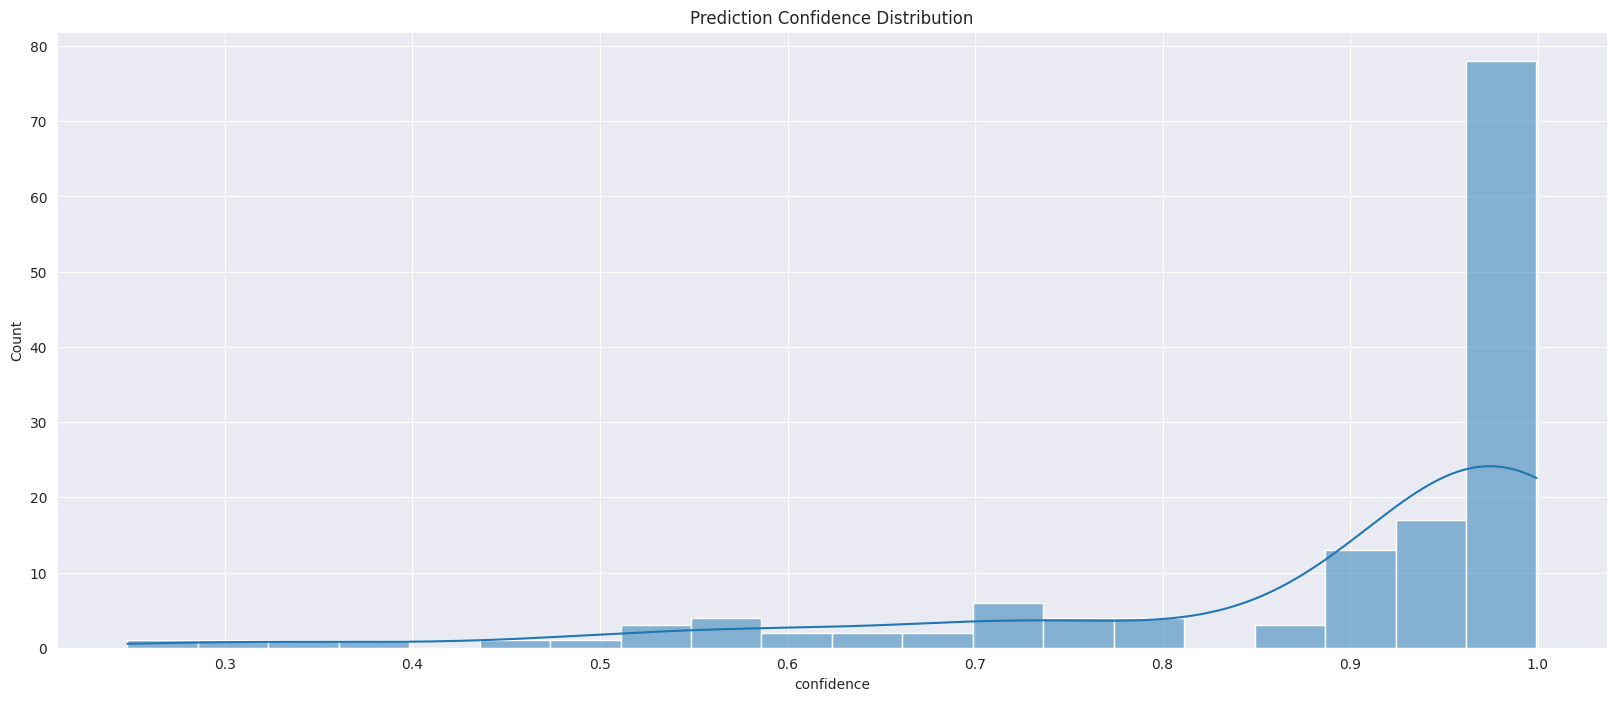

In [22]:
# Plot confidence distribution
plt.figure(figsize=(20, 8))
sns.histplot(conf_preds_df['confidence'], bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.show()

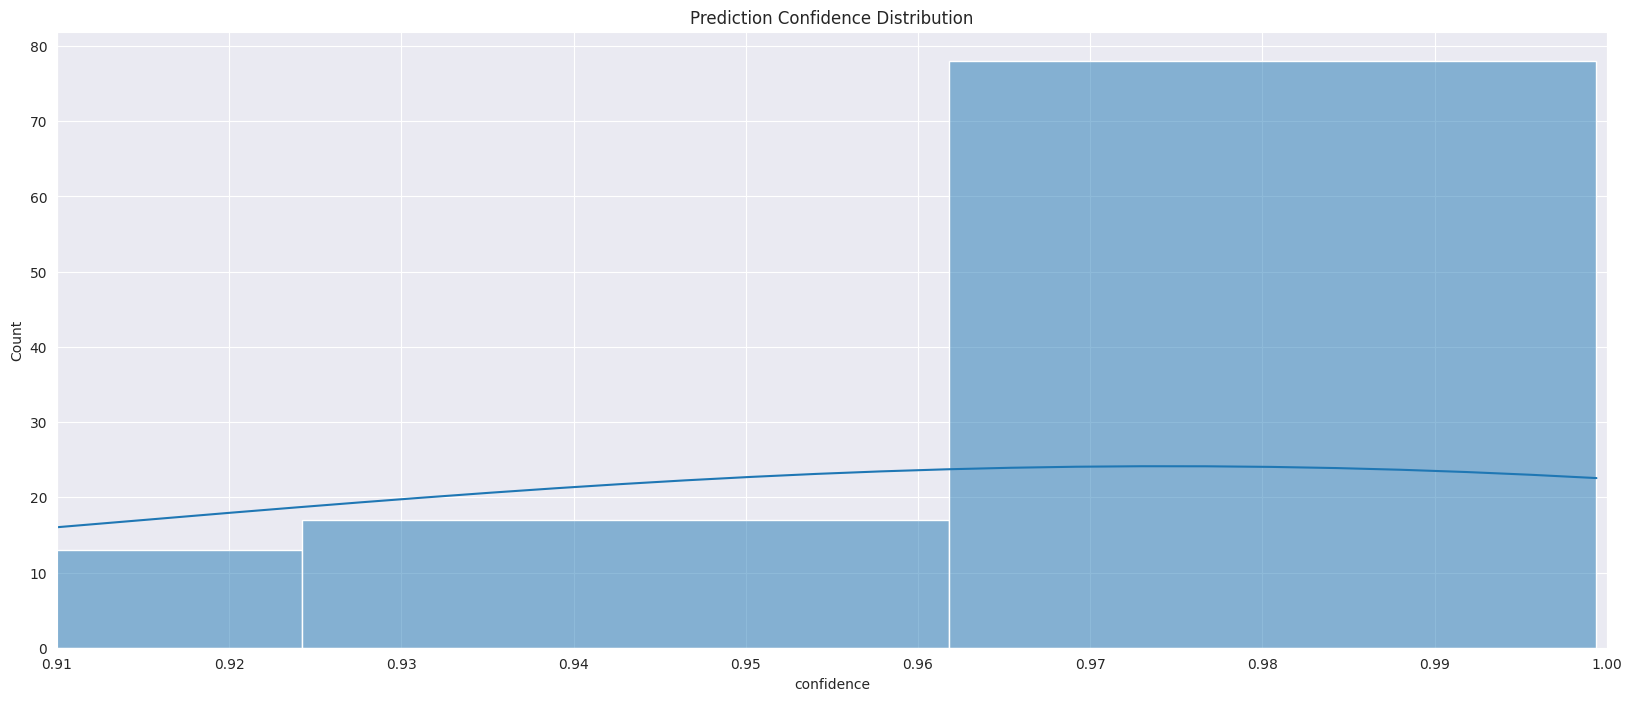

In [23]:
# Zooming in, restricting the plot to the range 0.91 and more
plt.figure(figsize=(20, 8))
sns.histplot(conf_preds_df['confidence'], bins=20, kde=True)

plt.xlim(0.91, 1.00)
plt.xticks(np.round(np.arange(0.91, 1.001, 0.01), 2))
plt.title("Prediction Confidence Distribution")
plt.show()

Looks like thresholds of 0.97 and above are giving us a decent number of samples, which is great. Now let’s see exactly how many pseudo-labeled images we have at each confidence level. This will help us decide how much synthetic data we can confidently include in the next training round


Let’s check the counts:

In [24]:
# Load the predictions with confidence
temp_df = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "initial_submission_with_confidence.csv"))

# Check how many samples we get for each threshold
for threshold in [0.95, 0.96, 0.97, 0.98, 0.99]:
    num_samples = (temp_df["confidence"] >= threshold).sum()
    print(f"Number of pseudo-labels with confidence ≥ {threshold}: {num_samples}")

Number of pseudo-labels with confidence ≥ 0.95: 88
Number of pseudo-labels with confidence ≥ 0.96: 79
Number of pseudo-labels with confidence ≥ 0.97: 72
Number of pseudo-labels with confidence ≥ 0.98: 56
Number of pseudo-labels with confidence ≥ 0.99: 41


At 97% confidence, the pseudo-labeled data are actually super clean. But here's the thing, if we just relax the threshold a tiny bit to 96%, we actually gain ~5 more samples, bringing the total to ~84 out of 114 test images. That's a solid boost, considering how small our test set is

Well, I'm greedy 😄, our model would appreciate these additional images, so let's stick with the 96% threshold. 

But before that, let’s do a quick sanity check and visualize these images with their predicted labels. We want to make sure they look reasonable and not completely off

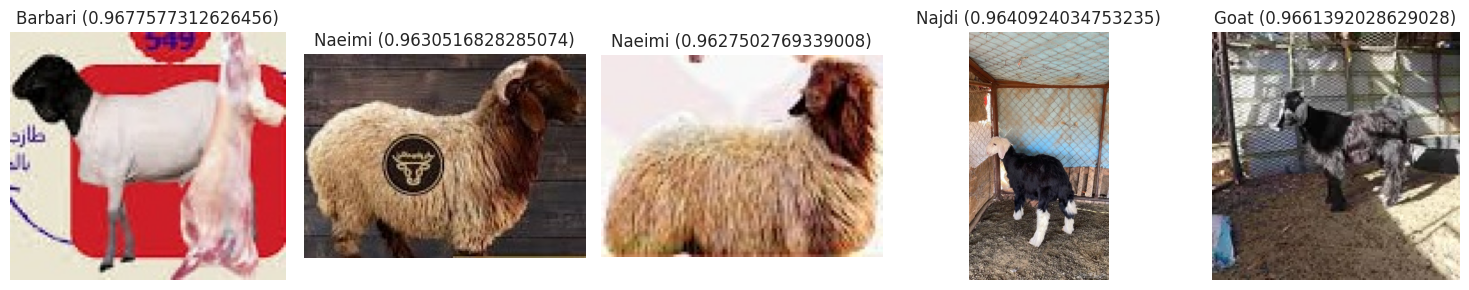

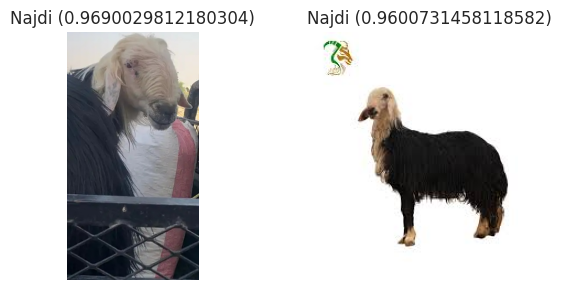

In [25]:
subset = temp_df[(temp_df["confidence"] >= 0.96) & (temp_df["confidence"] < 0.97)].reset_index(drop=True)

for i in range(0, len(subset), 5):
    batch = subset.iloc[i:i+5]
    plt.figure(figsize=(15, 3))
    for j, row in batch.iterrows():
        img_path = os.path.join(CONFIG.test_dir, row["filename"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, j % 5 + 1)
        plt.imshow(img)
        plt.title(f'{row["label"]} ({row["confidence"]})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [26]:
print("=" * 60)
print("PHASE 2: Pseudo-Label Generation")
print("=" * 60)

# Generate pseudo-labels with high threshold
pseudo_df = generate_pseudo_labels(models, test_loader, threshold=0.96)
# convert index to categorcal labels (to be matched with train_df when we combine)
pseudo_df["label"] = pseudo_df["label"].map(idx2label)

PHASE 2: Pseudo-Label Generation


Generating pseudo labels ≥ 0.96 confidence: 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

Generated 79 pseudo-labels out of 144 test images
Excluded 65 low-confidence predictions


In [27]:
# Saving it
pseudo_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "pseudo_labels.csv"), index=False
)

In [28]:
# Analyze pseudo-label distribution
print(f"\nPseudo-label class distribution:")
print(pseudo_df["label"].value_counts().sort_index())


Pseudo-label class distribution:
label
Barbari     9
Goat       17
Harri       4
Naeimi      5
Najdi      15
Roman      18
Sawakni    11
Name: count, dtype: int64


## 5.2 K-Mean Clustering

Okay, so pseudo-labeling gave us a nice batch of confident samples, but what about the rest of the test set?

Instead of not considering them in our final training, we try to recover more clean samples through unsupervised clustering. Here's the idea:

- We pass all test images through our model and extract high-dimensional feature embeddings from the penultimate layer
- Then, we use KMeans (with k=7 for our 7 classes) to group these features into clusters
- Finally, we infer the class of each cluster by checking which pseudo-labels (from our earlier step) dominate that cluster

Once we’ve got cluster labels, we compute a cluster purity score: how consistent is each cluster internally? If a cluster mostly contains images with the same pseudo-label, we call it a pure cluster

To be safe, we only keep clusters with ≥ 90% purity, and even then, we extract only the most "central" samples, ones closest to the cluster center in feature space. These are the ones we're most confident about

PHASE 3: K-Mean Clustering


Loading models: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]



Loaded 5 models
144 test images loaded.
Using 5 ensemble models.
Using 5 models for feature extraction


Extracting features: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Number of clusters found: 7


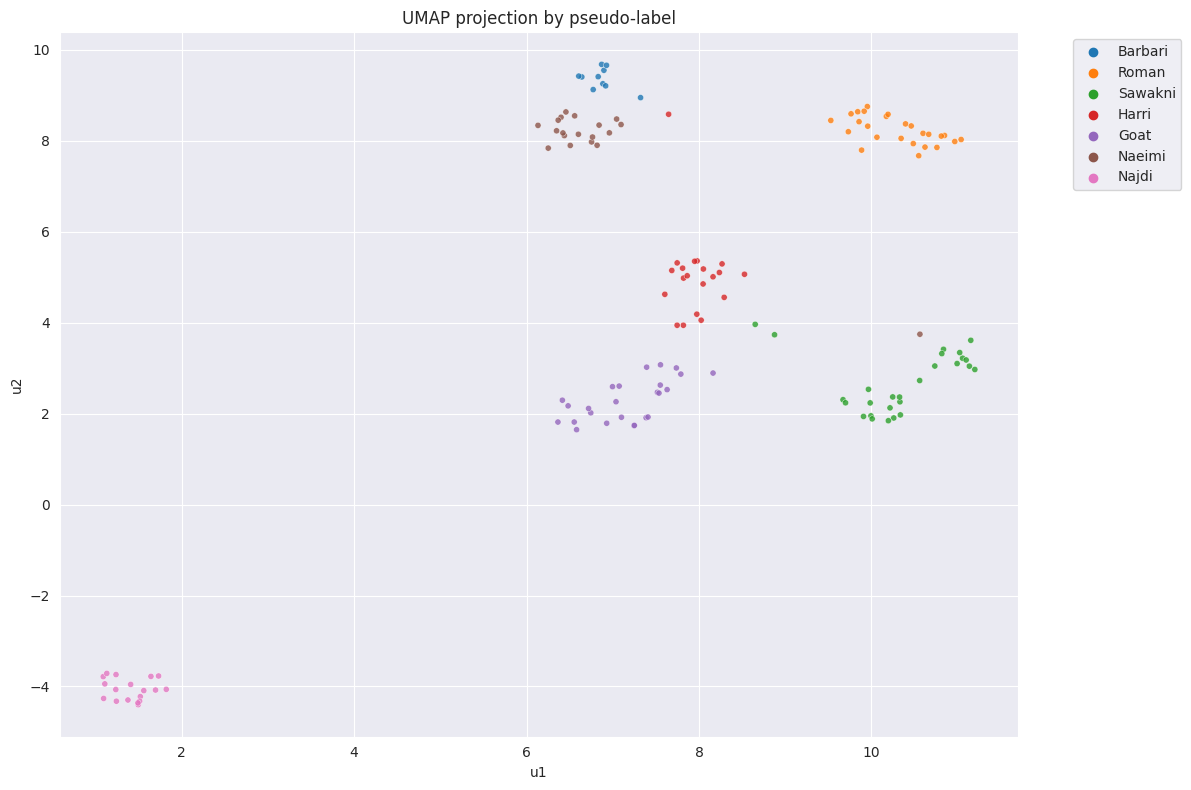

Clustered CSV saved to processed_data/clustered_test_results.csv
Calculating cluster purity...
Building merged CSV...
Selected purity threshold: 0.9
Original train samples: 682
Pseudo labeled samples: 79
Cluster samples after purity filtering and core sample filtering: 34
Merged CSV saved to processed_data/pseudo_clustered_merged.csv
Total samples after merging: 795


In [29]:
pseudo_df = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "pseudo_labels.csv"))
train_df = pd.read_csv(CONFIG.train_csv)
output_dir = CONFIG.processed_data_dir

print("=" * 60)
print("PHASE 3: K-Mean Clustering")
print("=" * 60)

clusterer = KMeansClustering(pseudo_df=pseudo_df, train_df=train_df, output_dir=output_dir)
df_clusters, merged_df = clusterer.run()

So, the clustering step gave us **~32 extra images** with a **purity threshold of 0.9**, that’s 32 confident samples we didn’t have before. Earlier, during pseudo-labeling, we skipped anything below 96% confidence. These new samples came straight from the model’s feature space, got grouped using KMeans, and we kept only the clusters that were internally consistent (i.e., pure).

So now, our **synthetic dataset is getting richer**, made up of:

- trusted samples from `train.csv` images (with 100% confidence)
- `pseudo_labels.csv` predictions (~97% confident from the model)
- and now these brand new **clustered confident samples**  pulled from the high-purity clusters

Let’s dig into the clustering results and check how well the clusters align with the pseudo labels

We’ve got two main DataFrames to explore:


1. `df_clusters`: the full clustering result, with columns like `filename`, `cluster`, `u1`, `u2`, `pred_label`, and `pconf` (confidence from the pseudo-labeling phase)
2. `merged_df`: the filtered & merged dataset with `filename`, `label`, `confidence`, and `source` (train/pseudo/cluster) (train / pseudo / cluster). This is what we’ll actually use for **retraining**

In [30]:
# test dataset, with pseudo confidence (model's output), predicted label (pseudo-labeling), and cluster id (KMeans clustering)

display(df_clusters)

filename  cluster         u1        u2 pred_label     pconf
0    0306fa89.jpg        4   6.830264  9.409830    Barbari  0.993924
1    0345e3ca.jpg        2  10.620441  7.861189      Roman  0.976224
2    0551a473.jpg        0   9.907362  1.938444    Sawakni  0.999001
3    06e1783d.jpg        3   7.603305  4.624169      Harri       NaN
4    08b9981b.jpg        4   6.640676  9.404335    Barbari  0.967921
..            ...      ...        ...       ...        ...       ...
139  f3e7b1fe.jpg        2  10.809462  8.103513      Roman  0.993808
140  faadf33d.jpg        2  11.039318  8.028120      Roman  0.995957
141  fbf2e74c.jpg        0  10.558896  2.727984    Sawakni       NaN
142  ff19c491.jpg        0  10.992763  3.100978    Sawakni       NaN
143  ffa67e5c.jpg        3   7.647175  8.583449      Harri       NaN

[144 rows x 6 columns]

- **filename** is the image filename (from the test set)
- **cluster** is the ID of the cluster this image was assigned to by KMeans. Images in the same cluster share visual similarity based on learned features
- **u1, u2** are the 2D UMAP coordinates (embeddings), used for visualizing clusters. These reduce the complex features into two numbers so we can plot them nicely
- **pred_label** is the predicted label for this image, (based on the most other common pseudo-label, lol) in its cluster, kind of a "majority guess"
- **pconf**, the model’s pseudo-label confidence. If this is NaN, it means the image didn’t meet the confidence threshold during pseudo-labeling, so it was only included through clustering

In [31]:
# The new dataset we will use in the next phase, they are a merge of train, and test data (pseudo, and cluster-labeled)
# The source tells us how we got the label.
display(merged_df)

filename    label  confidence   source
0    39d30b68.jpg   Naeimi         1.0    train
1    4a9853bd.jpg     Goat         1.0    train
2    d88facaa.jpg    Roman         1.0    train
3    a3f4f4af.jpg    Roman         1.0    train
4    16b31730.jpg   Naeimi         1.0    train
..            ...      ...         ...      ...
790  85fe3a81.jpg  Sawakni         0.9  cluster
791  a6518778.jpg  Sawakni         0.9  cluster
792  ab9babec.jpg  Sawakni         0.9  cluster
793  e8c1e128.jpg  Sawakni         0.9  cluster
794  ff19c491.jpg  Sawakni         0.9  cluster

[795 rows x 4 columns]

In [32]:
# number of samples in each cluster
df_clusters['cluster'].value_counts().sort_index()

cluster
0    27
1    18
2    25
3    20
4    10
5    25
6    19
Name: count, dtype: int64

In [33]:
# # The dominant pseudo-labels in each cluster
cluster_label_dist = df_clusters.groupby('cluster')['pred_label'].value_counts(normalize=True).unstack().fillna(0)
cluster_label_dist.style.background_gradient(cmap='Blues')

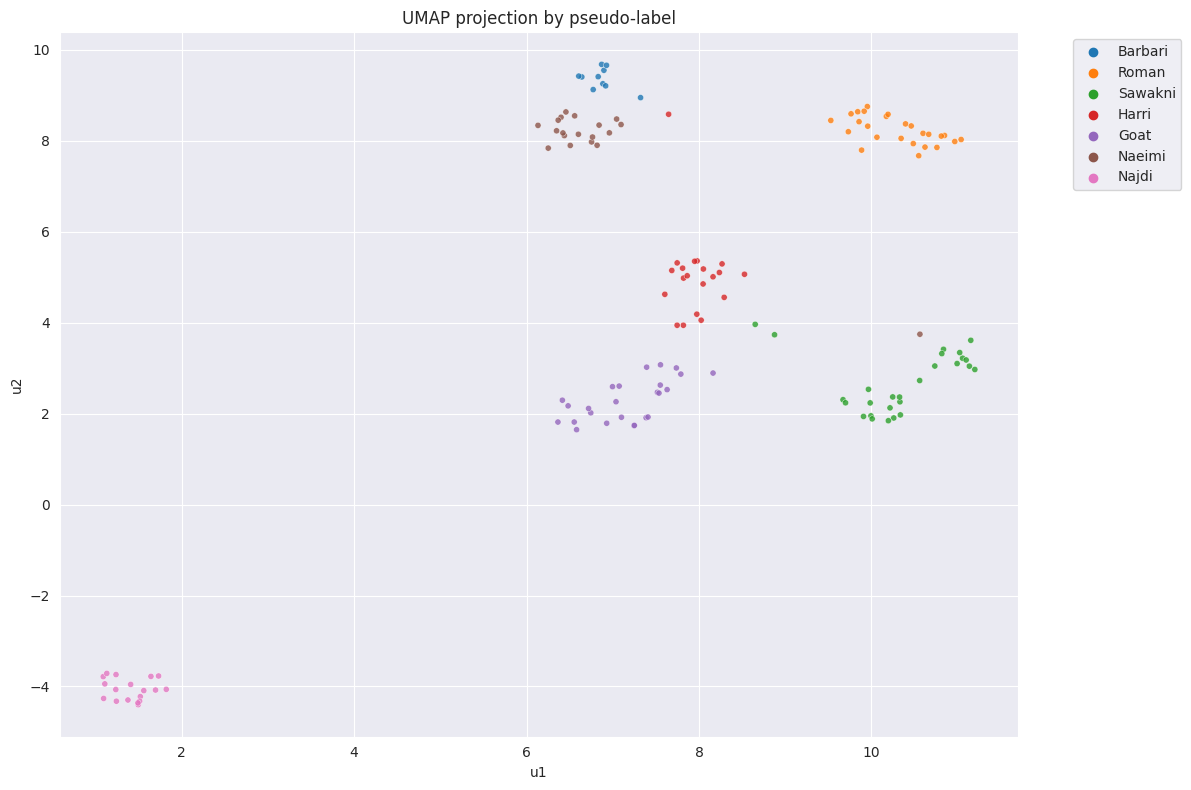

In [34]:
show_clusters(df_clusters)

As you can see, not all the clustered samples were grouped cleanly, some were scattered or didn't align well with the cluster's overall pattern. That’s why we needed to filter out the noisy ones

We first removed outliers, i.e., the samples labeled as noise or those belonging to inconsistent clusters. Then, for each remaining cluster, we did the following:

- Calculated the Euclidean distance between each sample and the cluster centroid using [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
- The centroid here is simply the mean feature vector of all samples in that cluster — it represents the "center" of the group
- This distance tells us how far a sample is from the cluster's core. Samples that are closer to the center are more likely to be reliable representatives of that class
- We then chose a cutoff based on a percentile — we used the 50th percentile (the median). Any sample closer than this distance was kept

This process gave us ~28 clean, representative samples from the clusters, the real core members of each group.

Let’s take a quick look at them

Number of clustered confident samples: 34


<Axes: title={'center': 'Clustered Label Distribution'}, xlabel='label'>

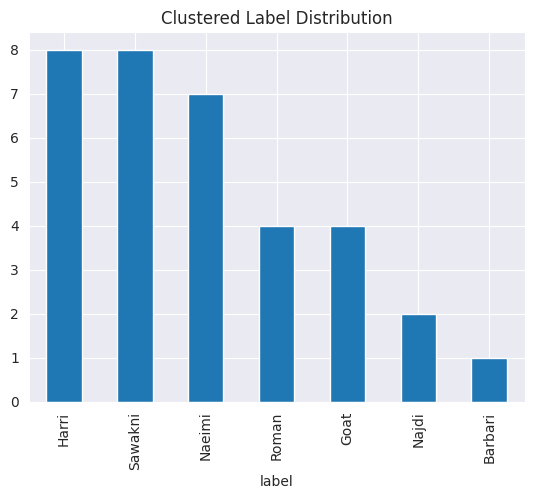

In [35]:
clustered_samples = merged_df[merged_df['source'] == 'cluster']
print(f"Number of clustered confident samples: {len(clustered_samples)}")
# Distribution of classes
clustered_samples['label'].value_counts().plot(kind='bar', title='Clustered Label Distribution')

In [36]:
clustered_samples[['filename', 'label', 'confidence']].head(30)

filename    label  confidence
761  163f0957.jpg    Harri         0.9
762  18a45994.jpg    Harri         0.9
763  2ebc35e2.jpg    Harri         0.9
764  30503f9d.jpg    Harri         0.9
765  47385f1a.jpg    Harri         0.9
766  a03784d5.jpg    Harri         0.9
767  bb126871.jpg    Harri         0.9
768  d72ea4f1.jpg    Harri         0.9
769  0cfc6a1e.jpg     Goat         0.9
770  3b138401.jpg     Goat         0.9
771  ac78a48d.jpg     Goat         0.9
772  b4bedb08.jpg     Goat         0.9
773  100bd43a.jpg    Roman         0.9
774  34ad5737.jpg    Roman         0.9
775  63be3b9a.jpg    Roman         0.9
776  e26ccad9.jpg    Roman         0.9
777  1081d46a.jpg   Naeimi         0.9
778  226dc6ee.jpg   Naeimi         0.9
779  3c5436f0.jpg   Naeimi         0.9
780  596f77ab.jpg   Naeimi         0.9
781  914de5e2.jpg   Naeimi         0.9
782  a9ed036d.jpg   Naeimi         0.9
783  f080711d.jpg   Naeimi         0.9
784  1432d91c.jpg  Barbari         0.9
785  247fb4df.jpg    Najdi         0.9
786  b69c3ee4.jpg    Najdi         0.9
787  4c9138a1.jpg  Sawakni         0.9
788  5d3b3719.jpg  Sawakni         0.9
789  6d66297e.jpg  Sawakni         0.9
790  85fe3a81.jpg  Sawakni         0.9

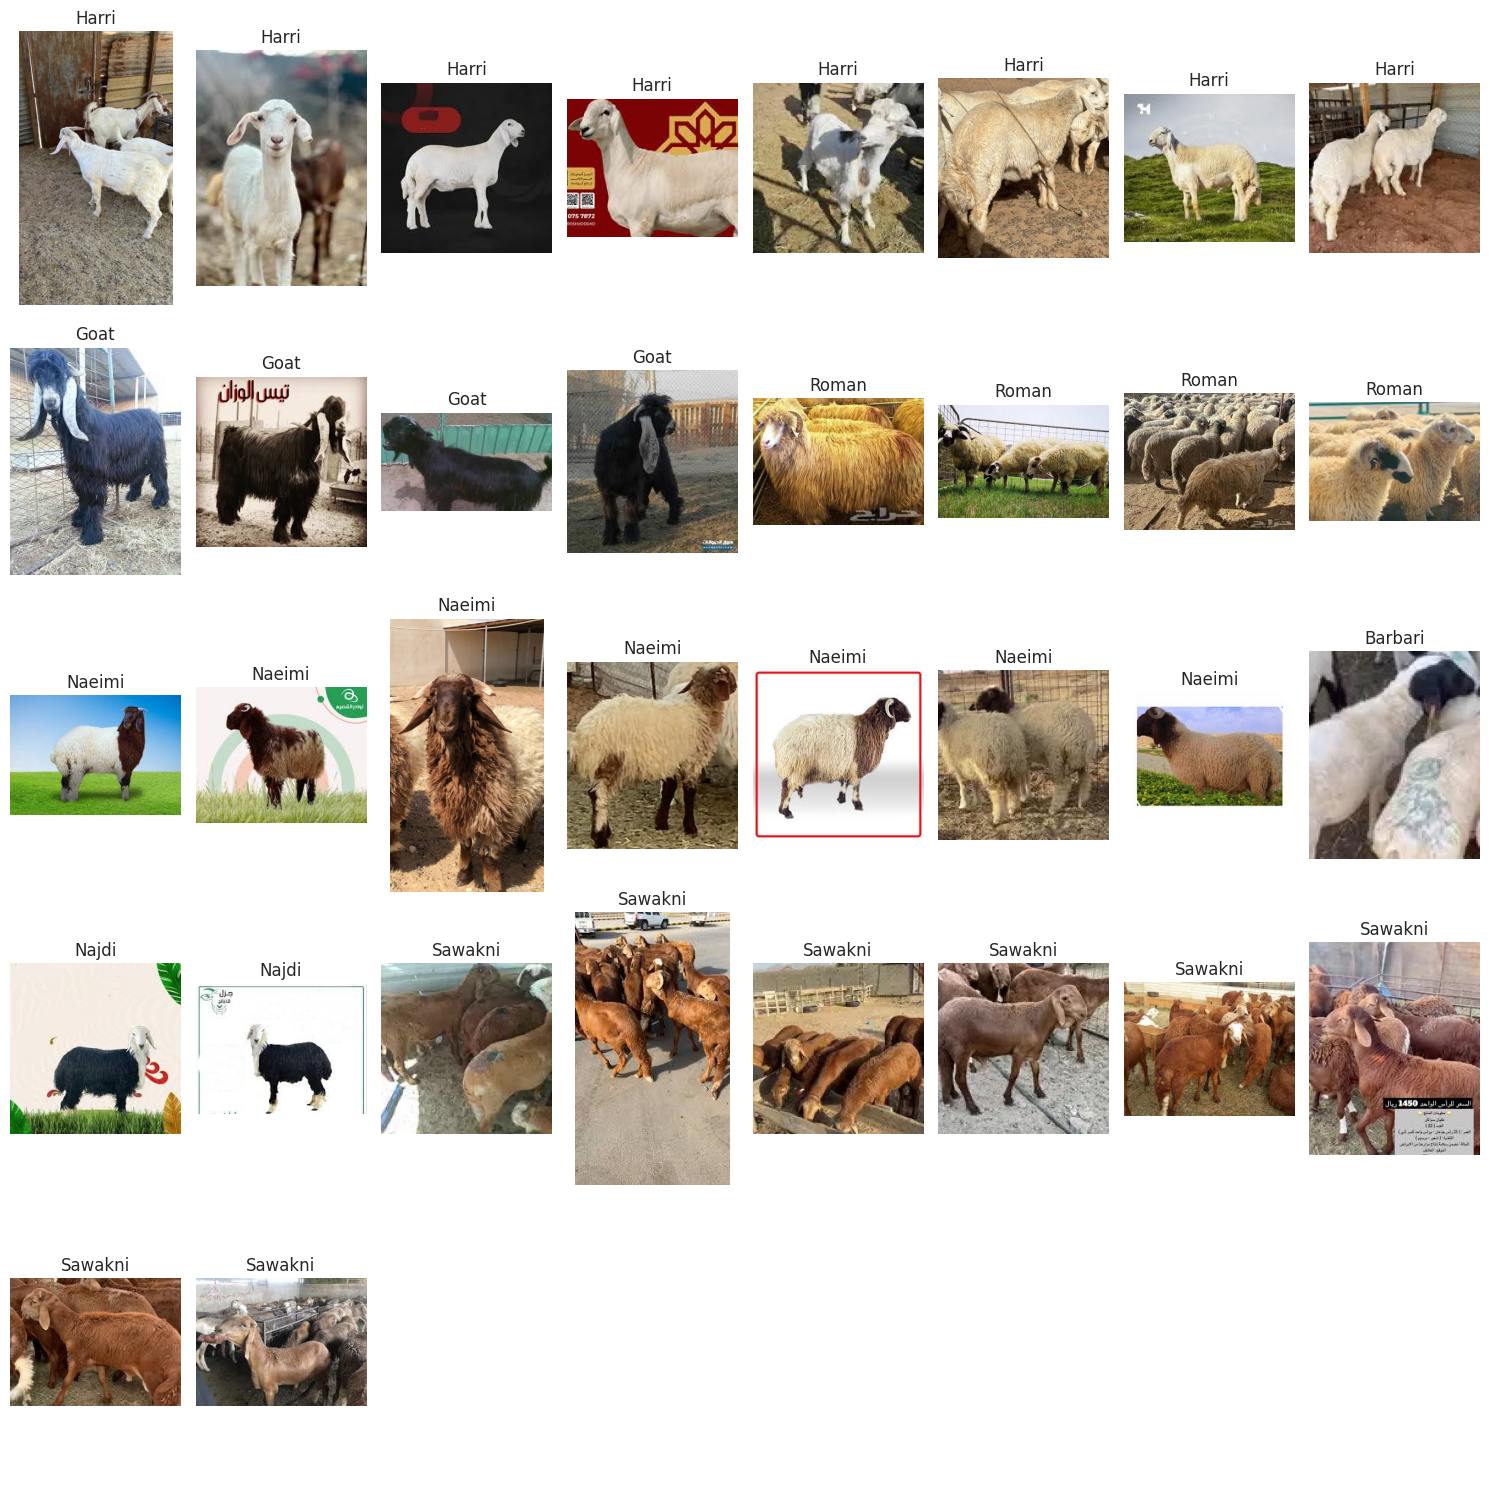

In [37]:
# lets plot them 
n_images = len(clustered_samples)
cols = 8
rows = math.ceil(n_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i, row in enumerate(clustered_samples.itertuples()):
    img_path = os.path.join(CONFIG.test_dir, row.filename) # test dir / filename
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(row.label) # label
    axes[i].axis('off')

# turn off any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

We just gained more clean data, sounds awesome, right? :’)

Now, let’s prepare this enriched dataset and kick off our final training phase!

<Axes: title={'center': 'Sample Count by Source'}, xlabel='source'>

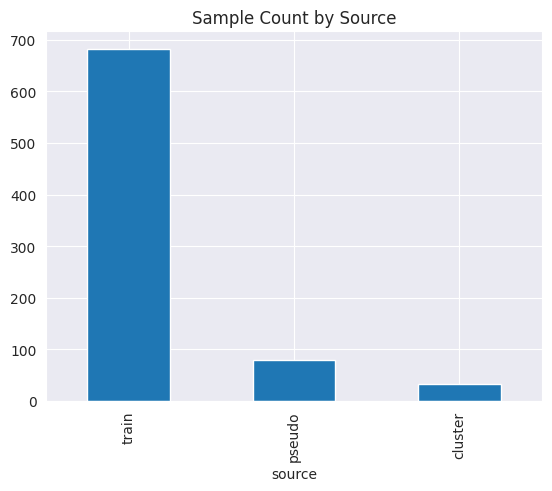

In [38]:
# count how many samples come from each source (train / pseudo / cluster)
merged_df['source'].value_counts().plot(kind='bar', title='Sample Count by Source')

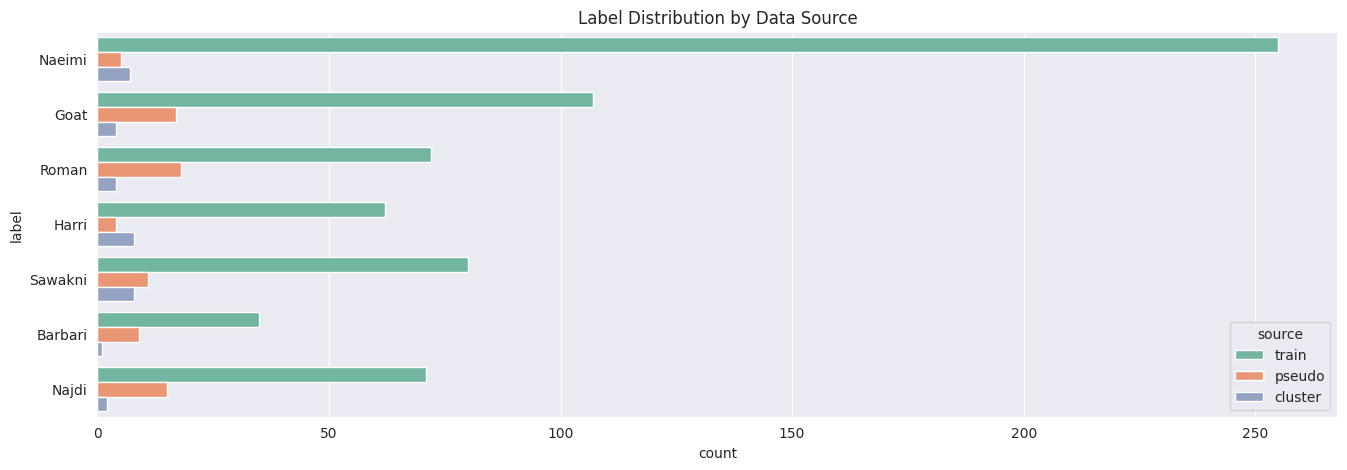

In [39]:
# we still got imbalanced dataset, but it's better than before
plt.figure(figsize=(16, 5))
sns.countplot(data=merged_df, y='label', hue='source', palette='Set2')
plt.title('Label Distribution by Data Source')
plt.show()

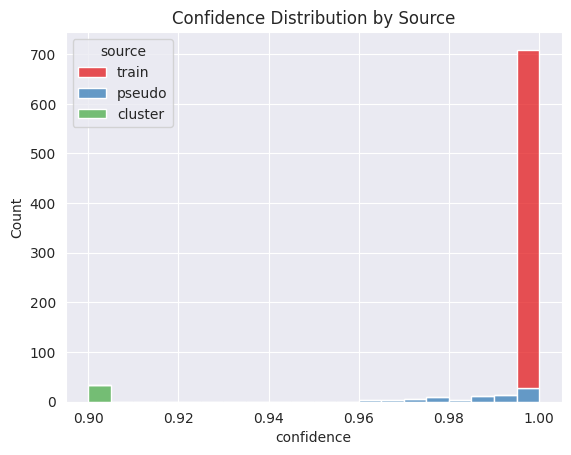

In [40]:
# conf histogram by source type (train = 1.0, pseudo ≈ 0.97, cluster = 0.9)
# cluster confidence is set to 0.9 as the purity threshold
# pseudo confidence is set to 0.97 as the threshold for pseudo-labeling
# train confidence is 1.0 as we know it's 100% confident
sns.histplot(
    data=merged_df,
    x='confidence',
    hue='source',
    bins=20,
    multiple='stack',
    palette='Set1'
)
plt.title('Confidence Distribution by Source')
plt.show()

# 6. Final Training

In [41]:
# Loading the original train set
merged_df = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "pseudo_clustered_merged.csv"))
print("Length of original training set: {}".format(len(merged_df)))
display(merged_df)

Length of original training set: 795


filename    label  confidence   source
0    39d30b68.jpg   Naeimi         1.0    train
1    4a9853bd.jpg     Goat         1.0    train
2    d88facaa.jpg    Roman         1.0    train
3    a3f4f4af.jpg    Roman         1.0    train
4    16b31730.jpg   Naeimi         1.0    train
..            ...      ...         ...      ...
790  85fe3a81.jpg  Sawakni         0.9  cluster
791  a6518778.jpg  Sawakni         0.9  cluster
792  ab9babec.jpg  Sawakni         0.9  cluster
793  e8c1e128.jpg  Sawakni         0.9  cluster
794  ff19c491.jpg  Sawakni         0.9  cluster

[795 rows x 4 columns]

Btw, from here on, we have nearly 800 training samples, and only ~34 images left for predictions, so I think it’s safe to train the model normally.No need for cross-validation, I’ll continue with cross-validation folds just to stay consistent with my earlier training strategy.

But for anyone interested, I do have a simple standard training function (non-folded) for reference, find it [here](https://github.com/ahmedsalim3/sheep-classification-challenge/blob/main/src/modeling/train_eval.py#L386-L532)

In [42]:
label2idx, idx2label = get_label_maps()
# Map labels to indices
merged_df["label"] = merged_df["label"].map(label2idx)

merged_df.head()

filename  label  confidence source
0  39d30b68.jpg      3         1.0  train
1  4a9853bd.jpg      1         1.0  train
2  d88facaa.jpg      5         1.0  train
3  a3f4f4af.jpg      5         1.0  train
4  16b31730.jpg      3         1.0  train

PHASE 4: Retraining with Train + Pseudo-Labeled + Clustered Synthetic Data

====================================================================== FOLD 1 ======================================================================
Train distribution: [36, 103, 59, 213, 71, 75, 79], Length: 636
Val distribution: [9, 25, 15, 54, 17, 19, 20], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 14.05it/s]


Fold 1 | Epoch 1 | Train Loss: 0.7313 | Train Acc: 0.4130 | Val Loss: 0.1224 | Val Acc: 0.8679 | Val F1 Macro: 0.8773 | Val F1 Weighted: 0.8734
New best F1-macro for Fold 1 at epoch 1. Model saved. Current Best F1-macro: 0.8773


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.94it/s]


Fold 1 | Epoch 2 | Train Loss: 0.2434 | Train Acc: 0.7437 | Val Loss: 0.0653 | Val Acc: 0.9245 | Val F1 Macro: 0.9171 | Val F1 Weighted: 0.9259
New best F1-macro for Fold 1 at epoch 2. Model saved. Current Best F1-macro: 0.9171


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.94it/s]


Fold 1 | Epoch 3 | Train Loss: 0.1271 | Train Acc: 0.8671 | Val Loss: 0.0684 | Val Acc: 0.9686 | Val F1 Macro: 0.9602 | Val F1 Weighted: 0.9689
New best F1-macro for Fold 1 at epoch 3. Model saved. Current Best F1-macro: 0.9602


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


Fold 1 | Epoch 4 | Train Loss: 0.1250 | Train Acc: 0.8703 | Val Loss: 0.0707 | Val Acc: 0.9686 | Val F1 Macro: 0.9626 | Val F1 Weighted: 0.9686
New best F1-macro for Fold 1 at epoch 4. Model saved. Current Best F1-macro: 0.9626


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.91it/s]


Fold 1 | Epoch 5 | Train Loss: 0.0838 | Train Acc: 0.8956 | Val Loss: 0.0831 | Val Acc: 0.9623 | Val F1 Macro: 0.9536 | Val F1 Weighted: 0.9626


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.94it/s]


Fold 1 | Epoch 6 | Train Loss: 0.0766 | Train Acc: 0.9288 | Val Loss: 0.0741 | Val Acc: 0.9748 | Val F1 Macro: 0.9696 | Val F1 Weighted: 0.9747
New best F1-macro for Fold 1 at epoch 6. Model saved. Current Best F1-macro: 0.9696


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.97it/s]


Fold 1 | Epoch 7 | Train Loss: 0.0343 | Train Acc: 0.9525 | Val Loss: 0.0665 | Val Acc: 0.9811 | Val F1 Macro: 0.9738 | Val F1 Weighted: 0.9810
New best F1-macro for Fold 1 at epoch 7. Model saved. Current Best F1-macro: 0.9738


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.91it/s]


Fold 1 | Epoch 8 | Train Loss: 0.0321 | Train Acc: 0.9557 | Val Loss: 0.0716 | Val Acc: 0.9811 | Val F1 Macro: 0.9738 | Val F1 Weighted: 0.9810


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.96it/s]


Fold 1 | Epoch 9 | Train Loss: 0.0302 | Train Acc: 0.9604 | Val Loss: 0.0705 | Val Acc: 0.9748 | Val F1 Macro: 0.9696 | Val F1 Weighted: 0.9747


Validating: 100%|██████████| 20/20 [00:01<00:00, 14.08it/s]


Fold 1 | Epoch 10 | Train Loss: 0.0362 | Train Acc: 0.9636 | Val Loss: 0.0892 | Val Acc: 0.9748 | Val F1 Macro: 0.9671 | Val F1 Weighted: 0.9747


Validating: 100%|██████████| 20/20 [00:01<00:00, 14.02it/s]


Fold 1 | Epoch 11 | Train Loss: 0.0316 | Train Acc: 0.9636 | Val Loss: 0.1034 | Val Acc: 0.9811 | Val F1 Macro: 0.9738 | Val F1 Weighted: 0.9810


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.95it/s]


Fold 1 | Epoch 12 | Train Loss: 0.0352 | Train Acc: 0.9636 | Val Loss: 0.1032 | Val Acc: 0.9811 | Val F1 Macro: 0.9738 | Val F1 Weighted: 0.9811
New best F1-macro for Fold 1 at epoch 12. Model saved. Current Best F1-macro: 0.9738
Early stopping at epoch 12

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.9000    1.0000    0.9474         9
           1     1.0000    1.0000    1.0000        25
           2     1.0000    0.8667    0.9286        15
           3     1.0000    0.9815    0.9907        54
           4     1.0000    1.0000    1.0000        17
           5     0.9048    1.0000    0.9500        19
           6     1.0000    1.0000    1.0000        20

    accuracy                         0.9811       159
   macro avg     0.9721    0.9783    0.9738       159
weighted avg     0.9830    0.9811    0.9811       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0]
 [ 1  0 13  0  0  1  0]
 [ 0  0  

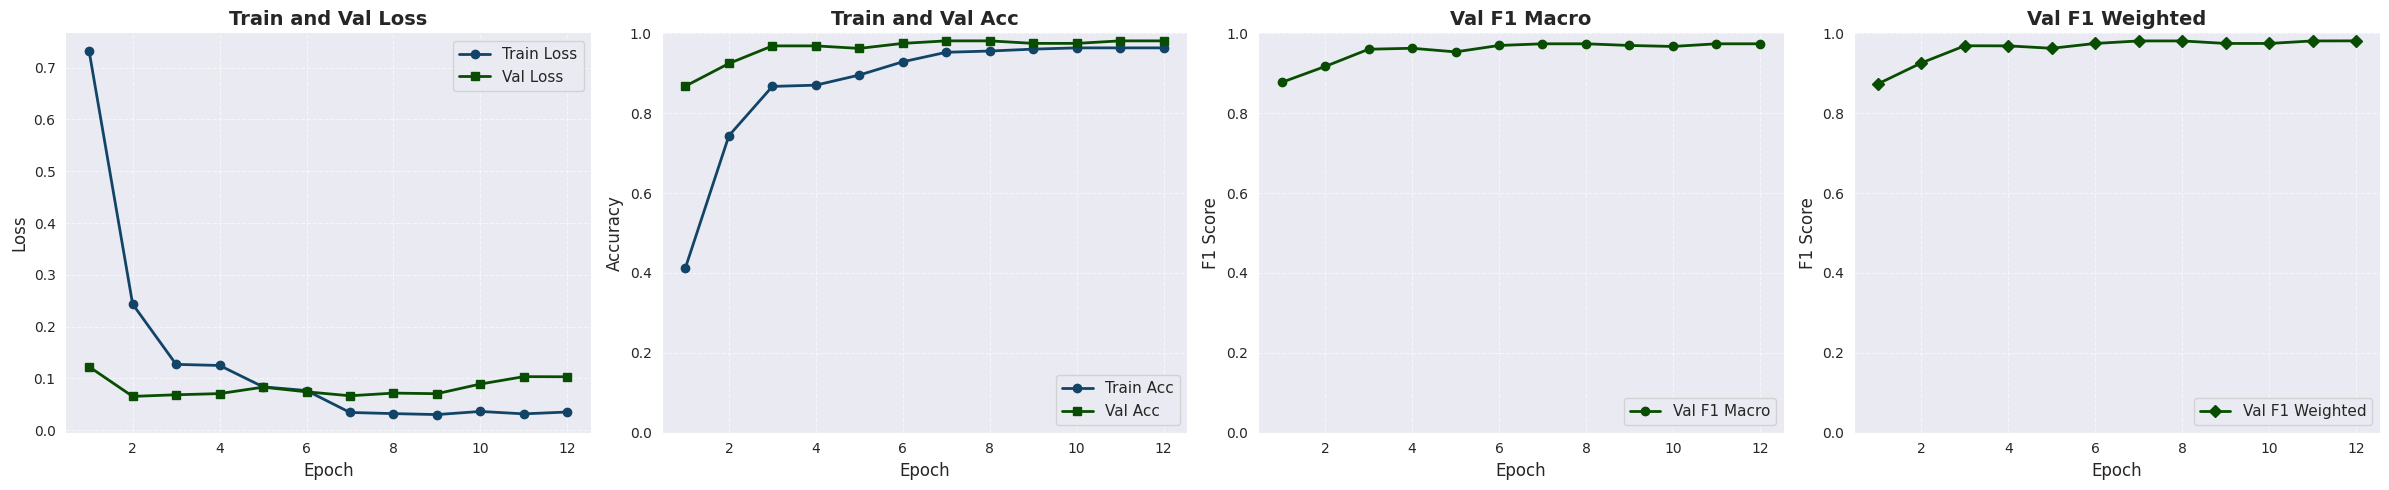


Fold 1 best F1: 0.9738

====================================================================== FOLD 2 ======================================================================
Train distribution: [36, 103, 59, 213, 71, 75, 79], Length: 636
Val distribution: [9, 25, 15, 54, 17, 19, 20], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]


Fold 2 | Epoch 1 | Train Loss: 0.7976 | Train Acc: 0.4256 | Val Loss: 0.2178 | Val Acc: 0.8302 | Val F1 Macro: 0.8247 | Val F1 Weighted: 0.8305
New best F1-macro for Fold 2 at epoch 1. Model saved. Current Best F1-macro: 0.8247


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


Fold 2 | Epoch 2 | Train Loss: 0.2171 | Train Acc: 0.7516 | Val Loss: 0.0987 | Val Acc: 0.8994 | Val F1 Macro: 0.8911 | Val F1 Weighted: 0.8993
New best F1-macro for Fold 2 at epoch 2. Model saved. Current Best F1-macro: 0.8911


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


Fold 2 | Epoch 3 | Train Loss: 0.1590 | Train Acc: 0.8244 | Val Loss: 0.0894 | Val Acc: 0.9245 | Val F1 Macro: 0.9187 | Val F1 Weighted: 0.9250
New best F1-macro for Fold 2 at epoch 3. Model saved. Current Best F1-macro: 0.9187


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


Fold 2 | Epoch 4 | Train Loss: 0.1318 | Train Acc: 0.8734 | Val Loss: 0.1170 | Val Acc: 0.9308 | Val F1 Macro: 0.9280 | Val F1 Weighted: 0.9298
New best F1-macro for Fold 2 at epoch 4. Model saved. Current Best F1-macro: 0.9280


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


Fold 2 | Epoch 5 | Train Loss: 0.0840 | Train Acc: 0.8940 | Val Loss: 0.1158 | Val Acc: 0.9560 | Val F1 Macro: 0.9558 | Val F1 Weighted: 0.9554
New best F1-macro for Fold 2 at epoch 5. Model saved. Current Best F1-macro: 0.9558


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


Fold 2 | Epoch 6 | Train Loss: 0.0726 | Train Acc: 0.9288 | Val Loss: 0.1034 | Val Acc: 0.9434 | Val F1 Macro: 0.9335 | Val F1 Weighted: 0.9432


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.10it/s]


Fold 2 | Epoch 7 | Train Loss: 0.0433 | Train Acc: 0.9604 | Val Loss: 0.0923 | Val Acc: 0.9623 | Val F1 Macro: 0.9601 | Val F1 Weighted: 0.9615
New best F1-macro for Fold 2 at epoch 7. Model saved. Current Best F1-macro: 0.9601


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]


Fold 2 | Epoch 8 | Train Loss: 0.0292 | Train Acc: 0.9557 | Val Loss: 0.1092 | Val Acc: 0.9560 | Val F1 Macro: 0.9588 | Val F1 Weighted: 0.9551


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Fold 2 | Epoch 9 | Train Loss: 0.0470 | Train Acc: 0.9604 | Val Loss: 0.1132 | Val Acc: 0.9497 | Val F1 Macro: 0.9428 | Val F1 Weighted: 0.9491


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


Fold 2 | Epoch 10 | Train Loss: 0.0369 | Train Acc: 0.9604 | Val Loss: 0.1406 | Val Acc: 0.9308 | Val F1 Macro: 0.9256 | Val F1 Weighted: 0.9305


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Fold 2 | Epoch 11 | Train Loss: 0.0466 | Train Acc: 0.9652 | Val Loss: 0.1361 | Val Acc: 0.9560 | Val F1 Macro: 0.9541 | Val F1 Weighted: 0.9548


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Fold 2 | Epoch 12 | Train Loss: 0.0274 | Train Acc: 0.9684 | Val Loss: 0.1447 | Val Acc: 0.9623 | Val F1 Macro: 0.9646 | Val F1 Weighted: 0.9619
New best F1-macro for Fold 2 at epoch 12. Model saved. Current Best F1-macro: 0.9646


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


Fold 2 | Epoch 13 | Train Loss: 0.0122 | Train Acc: 0.9699 | Val Loss: 0.1495 | Val Acc: 0.9434 | Val F1 Macro: 0.9457 | Val F1 Weighted: 0.9424


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.73it/s]


Fold 2 | Epoch 14 | Train Loss: 0.0275 | Train Acc: 0.9731 | Val Loss: 0.1369 | Val Acc: 0.9686 | Val F1 Macro: 0.9688 | Val F1 Weighted: 0.9681
New best F1-macro for Fold 2 at epoch 14. Model saved. Current Best F1-macro: 0.9688


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


Fold 2 | Epoch 15 | Train Loss: 0.0065 | Train Acc: 0.9858 | Val Loss: 0.1504 | Val Acc: 0.9623 | Val F1 Macro: 0.9630 | Val F1 Weighted: 0.9613


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


Fold 2 | Epoch 16 | Train Loss: 0.0188 | Train Acc: 0.9778 | Val Loss: 0.1364 | Val Acc: 0.9686 | Val F1 Macro: 0.9688 | Val F1 Weighted: 0.9681


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.20it/s]


Fold 2 | Epoch 17 | Train Loss: 0.0092 | Train Acc: 0.9747 | Val Loss: 0.1408 | Val Acc: 0.9623 | Val F1 Macro: 0.9646 | Val F1 Weighted: 0.9619


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


Fold 2 | Epoch 18 | Train Loss: 0.0063 | Train Acc: 0.9842 | Val Loss: 0.1405 | Val Acc: 0.9497 | Val F1 Macro: 0.9528 | Val F1 Weighted: 0.9482


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.10it/s]


Fold 2 | Epoch 19 | Train Loss: 0.0217 | Train Acc: 0.9794 | Val Loss: 0.1393 | Val Acc: 0.9560 | Val F1 Macro: 0.9568 | Val F1 Weighted: 0.9543
Early stopping at epoch 19

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     0.9259    1.0000    0.9615        25
           2     0.9333    0.9333    0.9333        15
           3     0.9636    0.9815    0.9725        54
           4     1.0000    1.0000    1.0000        17
           5     1.0000    0.8421    0.9143        19
           6     1.0000    1.0000    1.0000        20

    accuracy                         0.9686       159
   macro avg     0.9747    0.9653    0.9688       159
weighted avg     0.9697    0.9686    0.9681       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0]
 [ 0  1 14  0  0  0  0]
 [ 0  1  0 53  0  0  0]
 [ 0  0  0  0 17  0  0]
 [ 0  0  1  2  0 16  0]
 [ 0  0  0  0  0  0 20

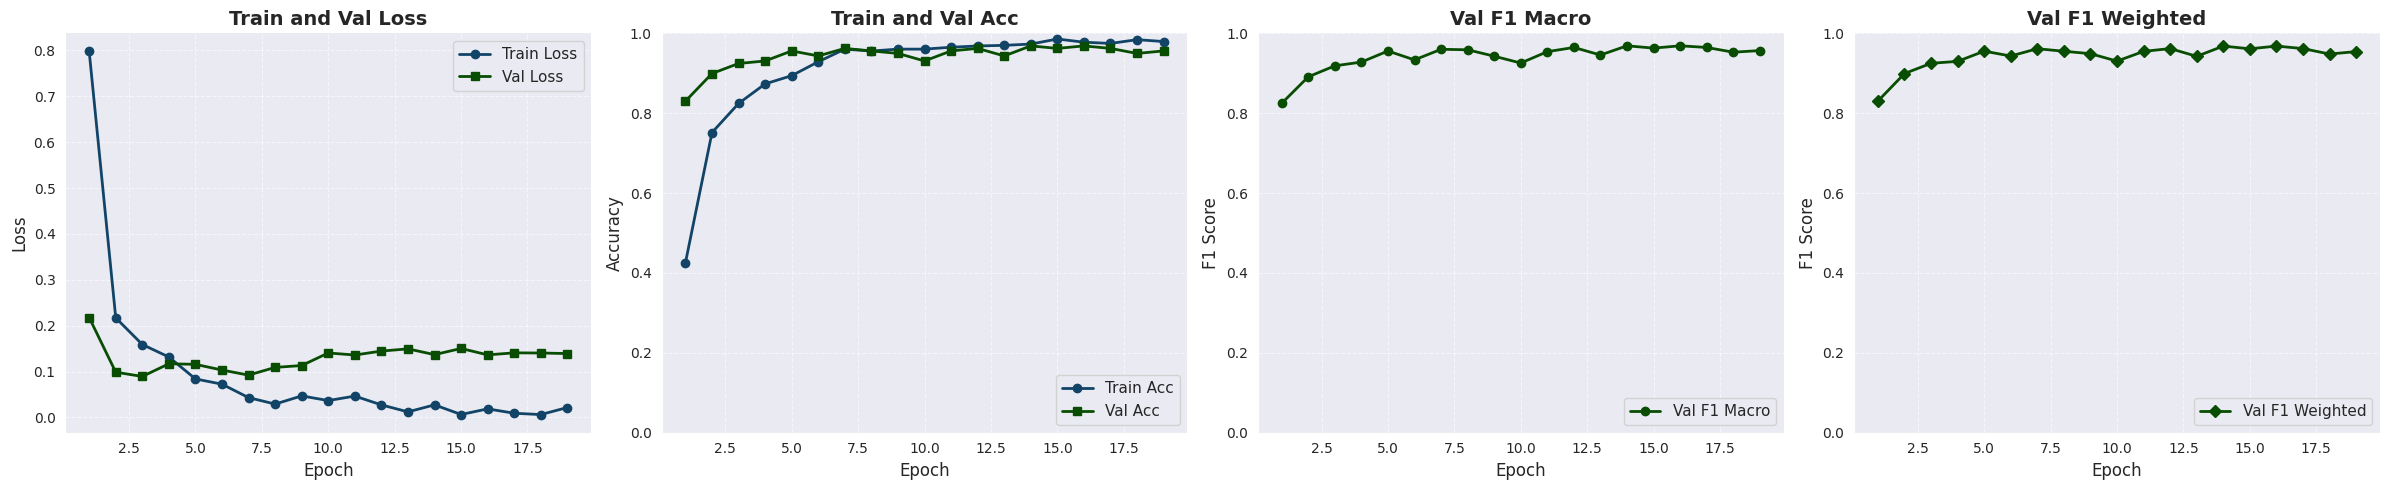


Fold 2 best F1: 0.9688

====================================================================== FOLD 3 ======================================================================
Train distribution: [36, 102, 59, 214, 70, 75, 80], Length: 636
Val distribution: [9, 26, 15, 53, 18, 19, 19], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]


Fold 3 | Epoch 1 | Train Loss: 0.7390 | Train Acc: 0.4130 | Val Loss: 0.1221 | Val Acc: 0.8050 | Val F1 Macro: 0.7907 | Val F1 Weighted: 0.8082
New best F1-macro for Fold 3 at epoch 1. Model saved. Current Best F1-macro: 0.7907


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.60it/s]


Fold 3 | Epoch 2 | Train Loss: 0.2207 | Train Acc: 0.7373 | Val Loss: 0.0588 | Val Acc: 0.9371 | Val F1 Macro: 0.9308 | Val F1 Weighted: 0.9367
New best F1-macro for Fold 3 at epoch 2. Model saved. Current Best F1-macro: 0.9308


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.47it/s]


Fold 3 | Epoch 3 | Train Loss: 0.1392 | Train Acc: 0.8165 | Val Loss: 0.0505 | Val Acc: 0.9560 | Val F1 Macro: 0.9491 | Val F1 Weighted: 0.9556
New best F1-macro for Fold 3 at epoch 3. Model saved. Current Best F1-macro: 0.9491


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.85it/s]


Fold 3 | Epoch 4 | Train Loss: 0.1151 | Train Acc: 0.8671 | Val Loss: 0.0748 | Val Acc: 0.9434 | Val F1 Macro: 0.9371 | Val F1 Weighted: 0.9411


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


Fold 3 | Epoch 5 | Train Loss: 0.0668 | Train Acc: 0.9225 | Val Loss: 0.1226 | Val Acc: 0.9371 | Val F1 Macro: 0.9262 | Val F1 Weighted: 0.9334


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.94it/s]


Fold 3 | Epoch 6 | Train Loss: 0.0798 | Train Acc: 0.9320 | Val Loss: 0.0837 | Val Acc: 0.9434 | Val F1 Macro: 0.9322 | Val F1 Weighted: 0.9416


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.65it/s]


Fold 3 | Epoch 7 | Train Loss: 0.0330 | Train Acc: 0.9573 | Val Loss: 0.0858 | Val Acc: 0.9560 | Val F1 Macro: 0.9482 | Val F1 Weighted: 0.9549


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s]


Fold 3 | Epoch 8 | Train Loss: 0.0362 | Train Acc: 0.9668 | Val Loss: 0.0801 | Val Acc: 0.9497 | Val F1 Macro: 0.9421 | Val F1 Weighted: 0.9479
Early stopping at epoch 8

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.9000    1.0000    0.9474         9
           1     1.0000    0.8846    0.9388        26
           2     0.8824    1.0000    0.9375        15
           3     0.9811    0.9811    0.9811        53
           4     1.0000    1.0000    1.0000        18
           5     0.9412    0.8421    0.8889        19
           6     0.9048    1.0000    0.9500        19

    accuracy                         0.9560       159
   macro avg     0.9442    0.9583    0.9491       159
weighted avg     0.9585    0.9560    0.9556       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 1 23  1  0  0  0  1]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0 52  0  1  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  1  1  0 16  1]
 [ 0  0  0  0  0  0 19]]

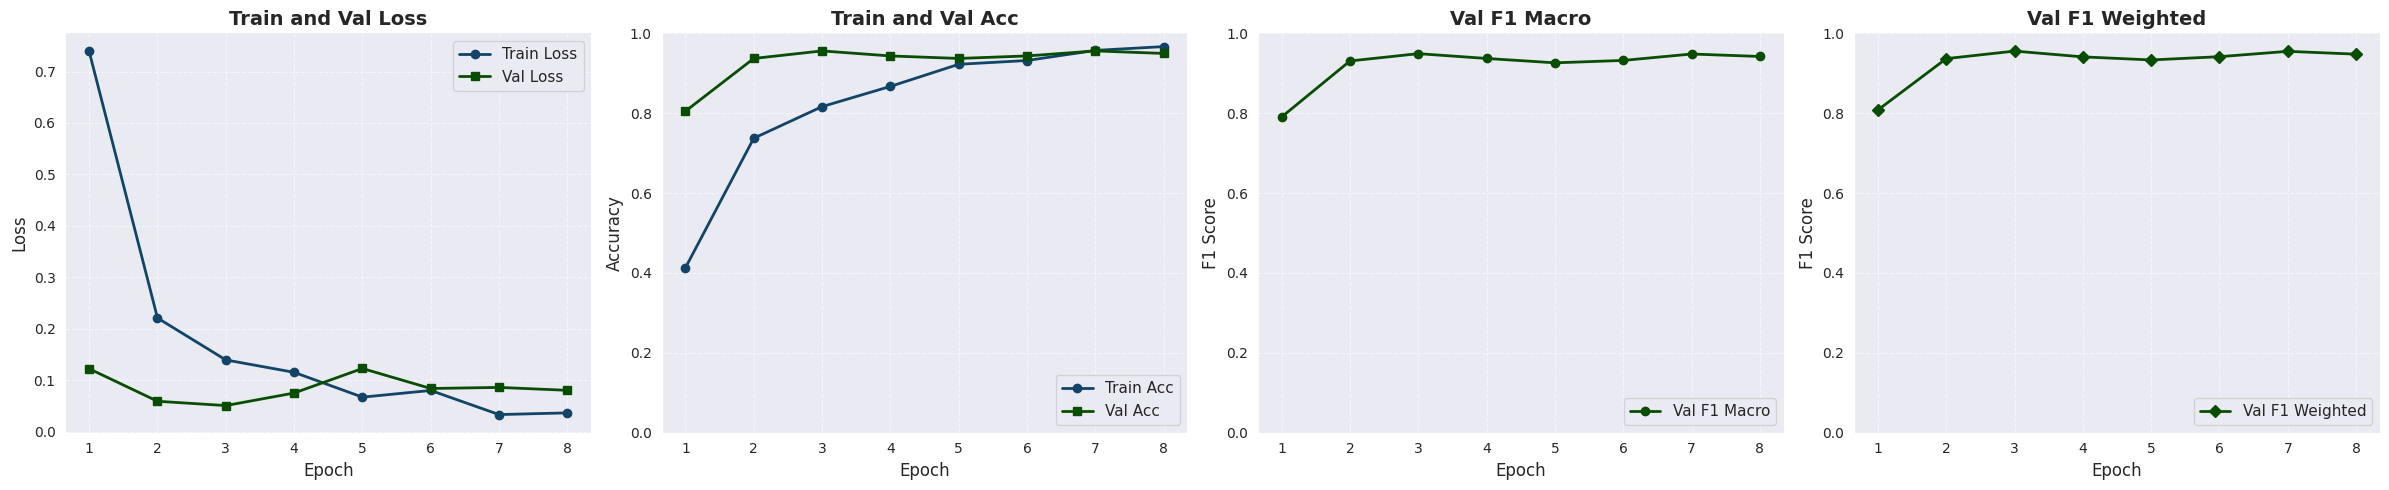


Fold 3 best F1: 0.9491

====================================================================== FOLD 4 ======================================================================
Train distribution: [36, 102, 60, 214, 70, 75, 79], Length: 636
Val distribution: [9, 26, 14, 53, 18, 19, 20], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.36it/s]


Fold 4 | Epoch 1 | Train Loss: 0.7266 | Train Acc: 0.4494 | Val Loss: 0.2285 | Val Acc: 0.7610 | Val F1 Macro: 0.7328 | Val F1 Weighted: 0.7483
New best F1-macro for Fold 4 at epoch 1. Model saved. Current Best F1-macro: 0.7328


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.15it/s]


Fold 4 | Epoch 2 | Train Loss: 0.2288 | Train Acc: 0.7484 | Val Loss: 0.1086 | Val Acc: 0.8616 | Val F1 Macro: 0.8551 | Val F1 Weighted: 0.8634
New best F1-macro for Fold 4 at epoch 2. Model saved. Current Best F1-macro: 0.8551


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.29it/s]


Fold 4 | Epoch 3 | Train Loss: 0.1374 | Train Acc: 0.8354 | Val Loss: 0.1144 | Val Acc: 0.8742 | Val F1 Macro: 0.8672 | Val F1 Weighted: 0.8762
New best F1-macro for Fold 4 at epoch 3. Model saved. Current Best F1-macro: 0.8672


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.32it/s]


Fold 4 | Epoch 4 | Train Loss: 0.1485 | Train Acc: 0.8687 | Val Loss: 0.0868 | Val Acc: 0.9245 | Val F1 Macro: 0.9234 | Val F1 Weighted: 0.9248
New best F1-macro for Fold 4 at epoch 4. Model saved. Current Best F1-macro: 0.9234


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.34it/s]


Fold 4 | Epoch 5 | Train Loss: 0.1084 | Train Acc: 0.8845 | Val Loss: 0.0691 | Val Acc: 0.9434 | Val F1 Macro: 0.9510 | Val F1 Weighted: 0.9444
New best F1-macro for Fold 4 at epoch 5. Model saved. Current Best F1-macro: 0.9510


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.12it/s]


Fold 4 | Epoch 6 | Train Loss: 0.0339 | Train Acc: 0.9367 | Val Loss: 0.1194 | Val Acc: 0.8994 | Val F1 Macro: 0.8970 | Val F1 Weighted: 0.9025


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s]


Fold 4 | Epoch 7 | Train Loss: 0.0270 | Train Acc: 0.9668 | Val Loss: 0.0939 | Val Acc: 0.9497 | Val F1 Macro: 0.9490 | Val F1 Weighted: 0.9505


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


Fold 4 | Epoch 8 | Train Loss: 0.0462 | Train Acc: 0.9557 | Val Loss: 0.0899 | Val Acc: 0.9057 | Val F1 Macro: 0.9043 | Val F1 Weighted: 0.9079


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.52it/s]


Fold 4 | Epoch 9 | Train Loss: 0.0356 | Train Acc: 0.9636 | Val Loss: 0.1028 | Val Acc: 0.9057 | Val F1 Macro: 0.9043 | Val F1 Weighted: 0.9079


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.25it/s]


Fold 4 | Epoch 10 | Train Loss: 0.0413 | Train Acc: 0.9509 | Val Loss: 0.0931 | Val Acc: 0.9308 | Val F1 Macro: 0.9256 | Val F1 Weighted: 0.9325
Early stopping at epoch 10

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     0.9615    0.9615    0.9615        26
           2     0.8750    1.0000    0.9333        14
           3     0.9792    0.8868    0.9307        53
           4     1.0000    1.0000    1.0000        18
           5     0.7826    0.9474    0.8571        19
           6     1.0000    0.9500    0.9744        20

    accuracy                         0.9434       159
   macro avg     0.9426    0.9637    0.9510       159
weighted avg     0.9498    0.9434    0.9444       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 25  1  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 0  1  0 47  0  5  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  1  0 18  0]
 [ 0  0  1  0  0  0 19

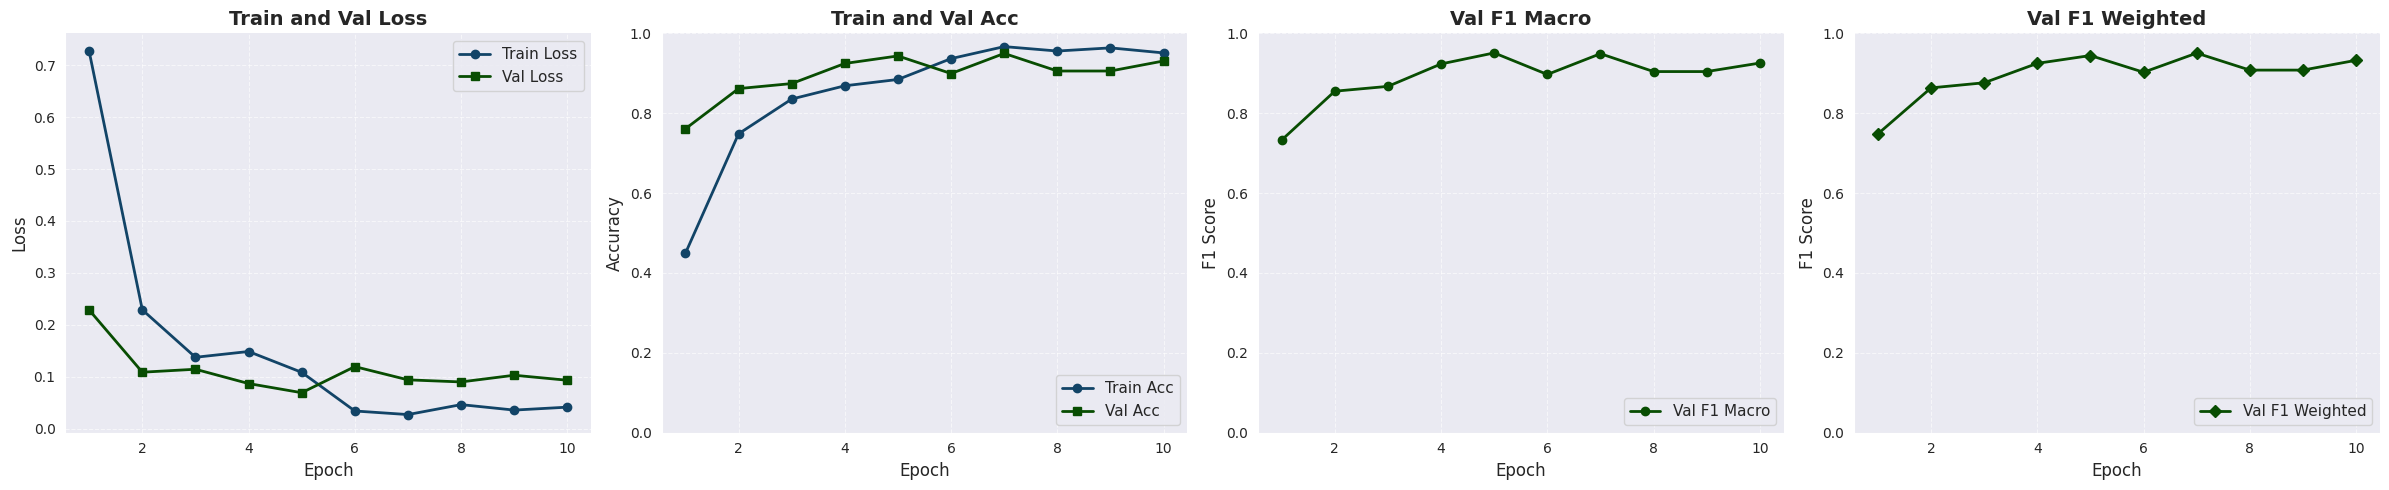


Fold 4 best F1: 0.9510

====================================================================== FOLD 5 ======================================================================
Train distribution: [36, 102, 59, 214, 70, 76, 79], Length: 636
Val distribution: [9, 26, 15, 53, 18, 18, 20], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.24it/s]


Fold 5 | Epoch 1 | Train Loss: 0.6197 | Train Acc: 0.5016 | Val Loss: 0.1829 | Val Acc: 0.8616 | Val F1 Macro: 0.8390 | Val F1 Weighted: 0.8625
New best F1-macro for Fold 5 at epoch 1. Model saved. Current Best F1-macro: 0.8390


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


Fold 5 | Epoch 2 | Train Loss: 0.2199 | Train Acc: 0.7911 | Val Loss: 0.1763 | Val Acc: 0.8931 | Val F1 Macro: 0.8717 | Val F1 Weighted: 0.8943
New best F1-macro for Fold 5 at epoch 2. Model saved. Current Best F1-macro: 0.8717


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Fold 5 | Epoch 3 | Train Loss: 0.1194 | Train Acc: 0.8497 | Val Loss: 0.1487 | Val Acc: 0.9119 | Val F1 Macro: 0.8869 | Val F1 Weighted: 0.9137
New best F1-macro for Fold 5 at epoch 3. Model saved. Current Best F1-macro: 0.8869


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


Fold 5 | Epoch 4 | Train Loss: 0.1075 | Train Acc: 0.8877 | Val Loss: 0.2160 | Val Acc: 0.8994 | Val F1 Macro: 0.8905 | Val F1 Weighted: 0.9046
New best F1-macro for Fold 5 at epoch 4. Model saved. Current Best F1-macro: 0.8905


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.24it/s]


Fold 5 | Epoch 5 | Train Loss: 0.0699 | Train Acc: 0.9320 | Val Loss: 0.1235 | Val Acc: 0.9371 | Val F1 Macro: 0.9186 | Val F1 Weighted: 0.9366
New best F1-macro for Fold 5 at epoch 5. Model saved. Current Best F1-macro: 0.9186


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.24it/s]


Fold 5 | Epoch 6 | Train Loss: 0.0350 | Train Acc: 0.9430 | Val Loss: 0.0656 | Val Acc: 0.9434 | Val F1 Macro: 0.9340 | Val F1 Weighted: 0.9441
New best F1-macro for Fold 5 at epoch 6. Model saved. Current Best F1-macro: 0.9340


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.20it/s]


Fold 5 | Epoch 7 | Train Loss: 0.0348 | Train Acc: 0.9462 | Val Loss: 0.0631 | Val Acc: 0.9560 | Val F1 Macro: 0.9475 | Val F1 Weighted: 0.9563
New best F1-macro for Fold 5 at epoch 7. Model saved. Current Best F1-macro: 0.9475


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.26it/s]


Fold 5 | Epoch 8 | Train Loss: 0.0323 | Train Acc: 0.9573 | Val Loss: 0.0793 | Val Acc: 0.9434 | Val F1 Macro: 0.9340 | Val F1 Weighted: 0.9441


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.34it/s]


Fold 5 | Epoch 9 | Train Loss: 0.0116 | Train Acc: 0.9826 | Val Loss: 0.0729 | Val Acc: 0.9560 | Val F1 Macro: 0.9432 | Val F1 Weighted: 0.9558


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.28it/s]


Fold 5 | Epoch 10 | Train Loss: 0.0347 | Train Acc: 0.9573 | Val Loss: 0.1569 | Val Acc: 0.9182 | Val F1 Macro: 0.9085 | Val F1 Weighted: 0.9213


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Fold 5 | Epoch 11 | Train Loss: 0.0408 | Train Acc: 0.9541 | Val Loss: 0.0857 | Val Acc: 0.9560 | Val F1 Macro: 0.9500 | Val F1 Weighted: 0.9556
New best F1-macro for Fold 5 at epoch 11. Model saved. Current Best F1-macro: 0.9500


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.27it/s]


Fold 5 | Epoch 12 | Train Loss: 0.0240 | Train Acc: 0.9778 | Val Loss: 0.1676 | Val Acc: 0.9434 | Val F1 Macro: 0.9340 | Val F1 Weighted: 0.9441


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


Fold 5 | Epoch 13 | Train Loss: 0.0223 | Train Acc: 0.9684 | Val Loss: 0.0921 | Val Acc: 0.9560 | Val F1 Macro: 0.9501 | Val F1 Weighted: 0.9566
New best F1-macro for Fold 5 at epoch 13. Model saved. Current Best F1-macro: 0.9501


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.32it/s]


Fold 5 | Epoch 14 | Train Loss: 0.0166 | Train Acc: 0.9858 | Val Loss: 0.0490 | Val Acc: 0.9811 | Val F1 Macro: 0.9775 | Val F1 Weighted: 0.9811
New best F1-macro for Fold 5 at epoch 14. Model saved. Current Best F1-macro: 0.9775


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s]


Fold 5 | Epoch 15 | Train Loss: 0.0192 | Train Acc: 0.9842 | Val Loss: 0.1198 | Val Acc: 0.9560 | Val F1 Macro: 0.9425 | Val F1 Weighted: 0.9557


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.28it/s]


Fold 5 | Epoch 16 | Train Loss: 0.0178 | Train Acc: 0.9763 | Val Loss: 0.1219 | Val Acc: 0.9560 | Val F1 Macro: 0.9425 | Val F1 Weighted: 0.9557


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.34it/s]


Fold 5 | Epoch 17 | Train Loss: 0.0059 | Train Acc: 0.9889 | Val Loss: 0.1207 | Val Acc: 0.9560 | Val F1 Macro: 0.9425 | Val F1 Weighted: 0.9557


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.95it/s]


Fold 5 | Epoch 18 | Train Loss: 0.0063 | Train Acc: 0.9889 | Val Loss: 0.0947 | Val Acc: 0.9686 | Val F1 Macro: 0.9591 | Val F1 Weighted: 0.9680


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.25it/s]


Fold 5 | Epoch 19 | Train Loss: 0.0166 | Train Acc: 0.9889 | Val Loss: 0.0872 | Val Acc: 0.9623 | Val F1 Macro: 0.9481 | Val F1 Weighted: 0.9617
Early stopping at epoch 19

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     0.9615    0.9615    0.9615        26
           2     0.9333    0.9333    0.9333        15
           3     1.0000    1.0000    1.0000        53
           4     0.9474    1.0000    0.9730        18
           5     1.0000    1.0000    1.0000        18
           6     1.0000    0.9500    0.9744        20

    accuracy                         0.9811       159
   macro avg     0.9775    0.9778    0.9775       159
weighted avg     0.9815    0.9811    0.9811       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 25  0  0  1  0  0]
 [ 0  1 14  0  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 18  0]
 [ 0  0  1  0  0  0 19

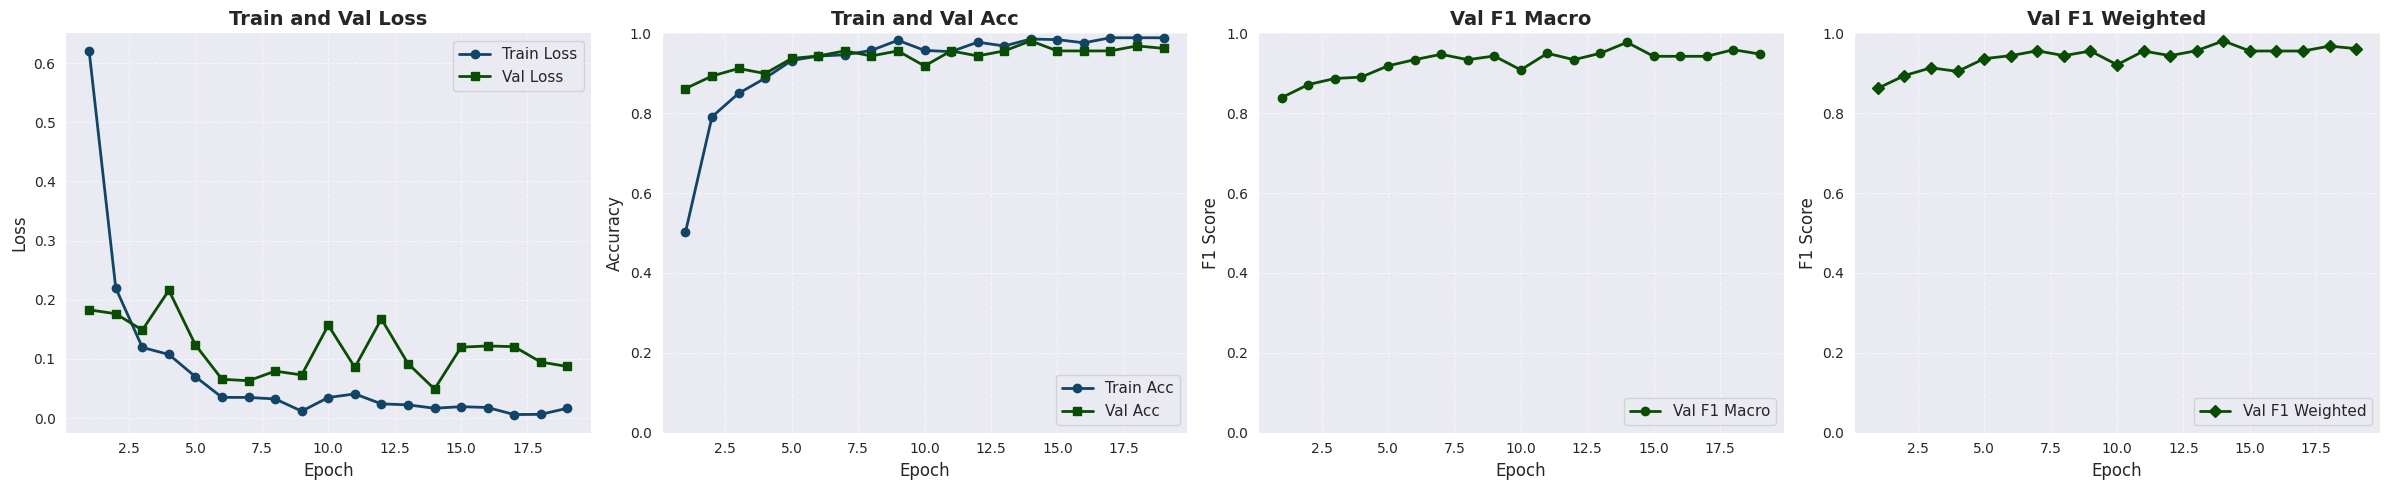


Fold 5 best F1: 0.9775

Cross-validation results:
Mean F1: 0.9640 ± 0.0118
Individual fold scores: [0.9737991507473625, 0.968804939053956, 0.9490949850881857, 0.9510095279543653, 0.9774576774576775]


In [43]:
# ===== Train with merged dataset =====
print("=" * 60)
print("PHASE 4: Retraining with Train + Pseudo-Labeled + Clustered Synthetic Data")
print("=" * 60)

final_fold_scores = train_cross_validation(
    merged_df, 
    pseudo_train=True, # MUST BE TRUE
    results_dir=PSEUDO_RESULTS_DIR
)

## 6.1 Final Predicton (Weighted Ensemble)

In [44]:
# Load the 10 models ( 5 initial + 5 pseudo-trained)
# also, make sure the models are loaded in order: CV first, then pseudo, 
# as we want to use the cross-validation scores as model weights

all_model_files = [f for f in os.listdir(CONFIG.models_dir) if f.endswith(".pth")]

cv_model_files = sorted([f for f in all_model_files if f.startswith("cv_fold_")])
pseudo_model_files = sorted([f for f in all_model_files if f.startswith("pseudo_fold_")])
sorted_model_files = cv_model_files + pseudo_model_files

models = load_models(sorted_model_files)

# Load the test set
test_loader = load_test_data()

# Load CV scores for weighting
cv_scores = np.load(os.path.join(CONFIG.models_dir, "cv_fold_scores.npy"))
pseudo_scores = np.load(os.path.join(CONFIG.models_dir, "pseudo_fold_scores.npy"))
print(f"\nCV Scores (Clean): {cv_scores}")
print(f"CV Scores (Pseudo-labeled + Clustered): {pseudo_scores}")

Loading models: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Loaded 10 models
Test set size: 144, batch size: 8

CV Scores (Clean): [0.93312415 0.93773741 0.94040965 0.98106079 0.99332203]
CV Scores (Pseudo-labeled + Clustered): [0.97379915 0.96880494 0.94909499 0.95100953 0.97745768]


In most scenarios, we should never trust pseudo-labels that much, they are a synthetic dataset that mimics the characteristics of real data, and they're generated artificially. that's why it's usually better to set a penalty to their models, like down-weighting their loss contribution, while giving higher importance to clean, manually labeled data

However, in this case, given the strict confidence thresholds we applied when generating the pseudo-labels (like 0.97+ and 90+ for clustering), I decided to treat them equally. I trust the model’s confidence enough to give pseudo-labeled samples the same weight as the clean ones

In [45]:
# Concatenate the scores
scores = np.concatenate([
    cv_scores,  # Initial 5 models (clean training)
    pseudo_scores, # * 0.9,  # Pseudo 5 models (no penalty)
])

In [46]:
# ======================
# Predict on test set
# ======================


all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader, fold_scores=scores)

# We can also treat all models equally, without using model weights (cross-validation mean scores and pseudo cross-validation mean scores)
# all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader)

Predicting: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Total predictions: 144
Average confidence: 0.8959
Min confidence: 0.3640
Max confidence: 0.9990

Model 1 | Weight: 0.097 | Fold score: 0.9331 | Type: Initial
Model 2 | Weight: 0.098 | Fold score: 0.9377 | Type: Initial
Model 3 | Weight: 0.098 | Fold score: 0.9404 | Type: Initial
Model 4 | Weight: 0.102 | Fold score: 0.9811 | Type: Initial
Model 5 | Weight: 0.103 | Fold score: 0.9933 | Type: Initial
Model 6 | Weight: 0.101 | Fold score: 0.9738 | Type: Pseudo
Model 7 | Weight: 0.101 | Fold score: 0.9688 | Type: Pseudo
Model 8 | Weight: 0.099 | Fold score: 0.9491 | Type: Pseudo
Model 9 | Weight: 0.099 | Fold score: 0.9510 | Type: Pseudo
Model 10 | Weight: 0.102 | Fold score: 0.9775 | Type: Pseudo


In [47]:
# Convert labels back to original labels
label2idx, idx2label = get_label_maps()
all_labels = [idx2label[pred] for pred in all_preds]

# 7. Submission

In [48]:
# Create submission
submission_df = pd.DataFrame({
    "filename": all_filenames,
    "label": all_labels
})

submission_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "final_submission.csv"), 
    index=False
)

# Create submission with confidence
submission_conf_df = pd.DataFrame({
    "filename": all_filenames,
    "label": all_labels,
    "confidence": all_confidences,
})

submission_conf_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "final_submission_with_confidence.csv"), 
    index=False
)

print(f"Final submission saved with {len(submission_df)} predictions")

Final submission saved with 144 predictions


In [49]:
display(submission_df)
display(submission_conf_df)

filename    label
0    0306fa89.jpg  Barbari
1    0345e3ca.jpg    Roman
2    0551a473.jpg  Sawakni
3    06e1783d.jpg     Goat
4    08b9981b.jpg  Barbari
..            ...      ...
139  f3e7b1fe.jpg    Roman
140  faadf33d.jpg    Roman
141  fbf2e74c.jpg  Sawakni
142  ff19c491.jpg  Sawakni
143  ffa67e5c.jpg  Barbari

[144 rows x 2 columns]

filename    label  confidence
0    0306fa89.jpg  Barbari    0.985400
1    0345e3ca.jpg    Roman    0.970035
2    0551a473.jpg  Sawakni    0.997909
3    06e1783d.jpg     Goat    0.577968
4    08b9981b.jpg  Barbari    0.950667
..            ...      ...         ...
139  f3e7b1fe.jpg    Roman    0.992934
140  faadf33d.jpg    Roman    0.995926
141  fbf2e74c.jpg  Sawakni    0.846196
142  ff19c491.jpg  Sawakni    0.848559
143  ffa67e5c.jpg  Barbari    0.604558

[144 rows x 3 columns]

Let’s now check how things changed between the initial training phase (before we added pseudo-labels and clustering) and the final training phase (after enriching the dataset). Specifically, let’s see which images ended up with a different label, these are the ones where the model changed its mind after being exposed to more data

Let’s visualize those flipped predictions:

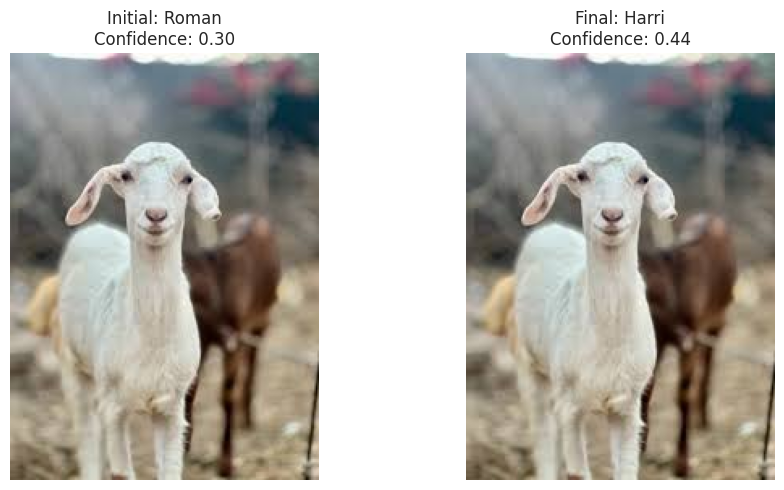

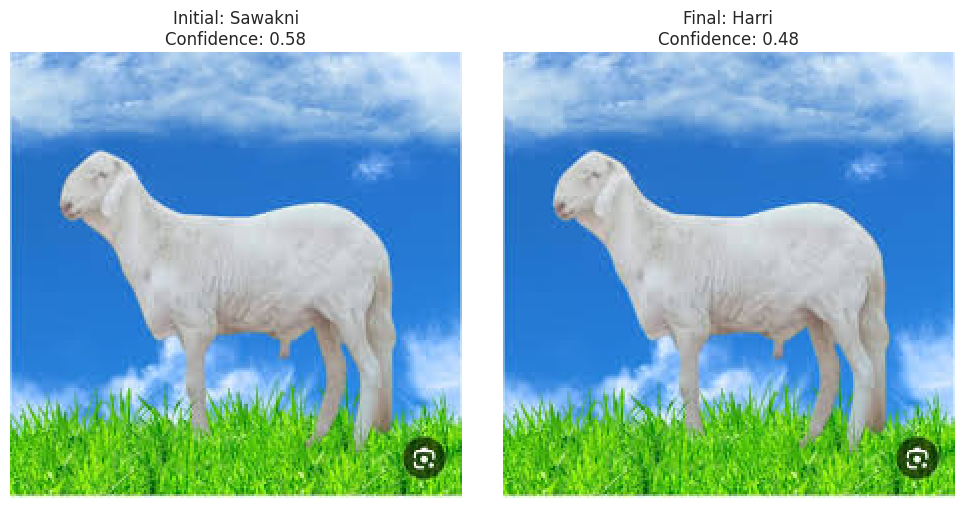

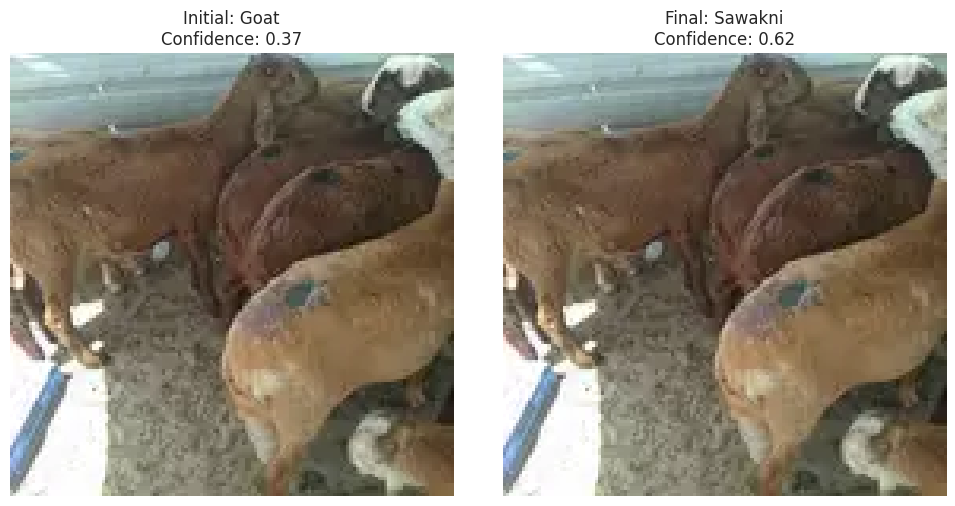

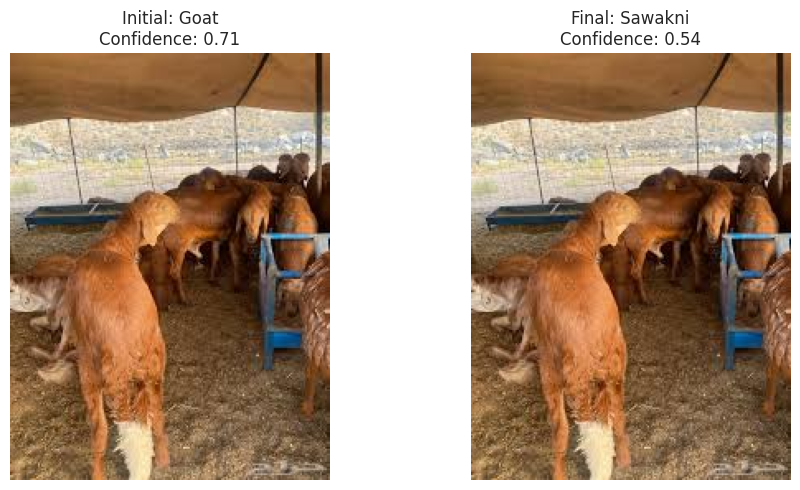

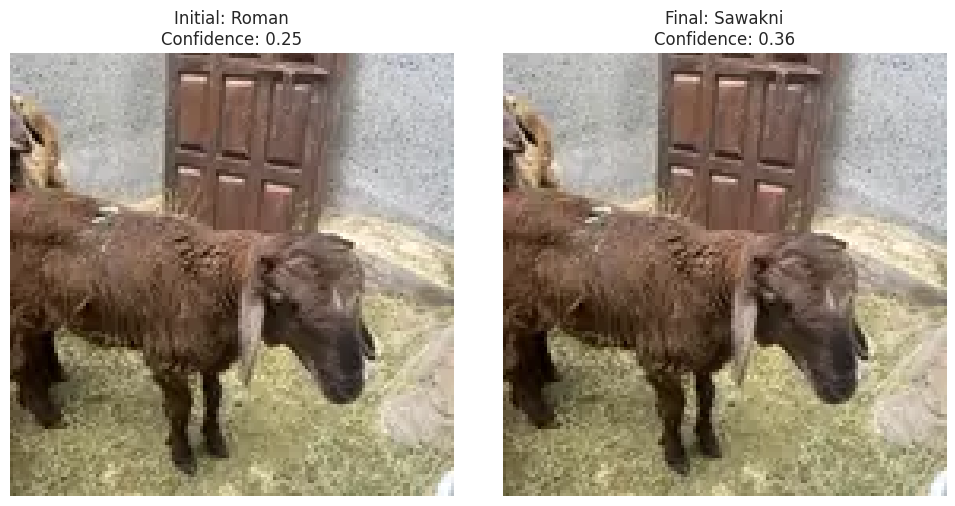

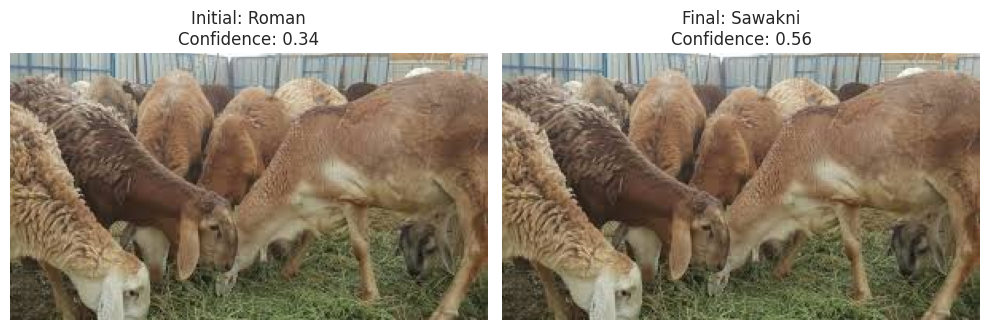

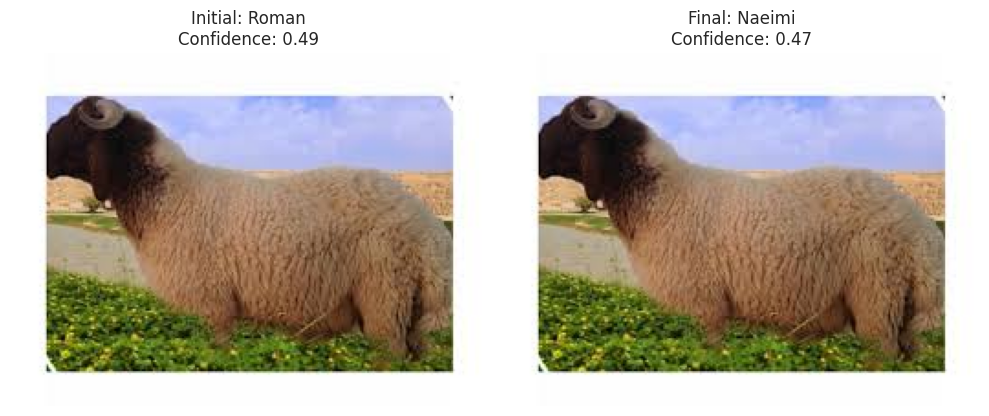

In [50]:
initial_res = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "initial_submission_with_confidence.csv"))
final_res = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "final_submission_with_confidence.csv"))
merged = initial_res.merge(final_res, on='filename', suffixes=('_initial', '_final'))

pred_changed = merged[merged['label_initial'] != merged['label_final']]
for _, row in pred_changed.iterrows():
    im = row['filename']
    
    img = cv2.imread(os.path.join(CONFIG.test_dir, im))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Initial: {row['label_initial']}\nConfidence: {row['confidence_initial']:.2f}")
    axes[0].axis('off')
    
    axes[1].imshow(img)
    axes[1].set_title(f"Final: {row['label_final']}\nConfidence: {row['confidence_final']:.2f}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

And here the sheeps saying **BAA** 🐑😂

That's it, we're done!

For those who are curious or want to dive deeper, I’ve pushed the full project to [GitHub](https://github.com/ahmedsalim3/sheep-classification-challenge/tree/main)
Hope you learned something from this walkthrough, or at least found it a little helpful

Until our next competition, stay curious and keep experimenting 

# 8. Refrences

- [Albumentations](https://albumentations.ai/)
-[*An Image is Worth 16x16 Words*](https://arxiv.org/pdf/2010.11929)
- [timm-model: vit_base_patch16_224.augreg_in21k_ft_in1k](https://huggingface.co/timm/vit_base_patch16_224.augreg_in21k_ft_in1k)
- [UMAP: Uniform Manifold Approximation and Projection](https://arxiv.org/pdf/1802.03426)
- [A Density-Based Algorithm for Discovering Clusters in Large Spatial Databaseswith Noise](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf)
- [Emerging Properties in Self-Supervised Vision Transformers](https://arxiv.org/pdf/2104.14294)
- [Self-Supervised Representation Learning](https://lilianweng.github.io/posts/2019-11-10-self-supervised/)